<a href="https://colab.research.google.com/github/IvanKatorgin/Computer-vision/blob/main/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Компьютерное зрение". Домашнее задание 3. Задачи детекции и сегментации. Каторгин И.П.

## Описание задания

В данном задании вам предстоит помочь The Nature Conservancy (https://www.nature.org/en-us/about-us/where-we-work/united-states/california/) в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель детектора:
https://github.com/a4tunado/lectures/blob/master/007/007-detection.ipynb. Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard (https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/leaderboard).

# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

## Подключимся к kaggle и загрузим датасет

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                   title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                              Car Price Dataset                            135KB  2025-01-26 19:53:28          10611        145  1.0              
adilshamim8/education-and-career-success              Education & Career Success.                  118KB  2025-02-03 05:24:20           2199         39  1.0              
sachinkumar62/datascience-job-data                    data science job data set                    247KB  2025-02-12 14:15:12            636         27  1.0              
anandshaw2001/netflix-movies-and-tv-shows             Netflix Movies and TV Shows                    1MB  2025-01-03 10:33:01          19061     

In [ ]:
# загрузим данные из Kaggle
! kaggle competitions download -c the-nature-conservancy-fisheries-monitoring

100% 2.11G/2.11G [00:20<00:00, 70.6MB/s]
100% 2.11G/2.11G [00:20<00:00, 112MB/s] 


In [ ]:
# проверка
! unzip -l the-nature-conservancy-fisheries-monitoring.zip

Archive:  the-nature-conservancy-fisheries-monitoring.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     3828  2019-12-11 23:27   sample_submission_stg1.csv.zip
    36697  2019-12-11 23:27   sample_submission_stg2.csv.zip
242205616  2019-12-11 23:27   test_stg1.zip
1152137421  2019-12-11 23:27   test_stg2.7z
872167582  2019-12-11 23:29   train.zip
---------                     -------
2266551144                     5 files


In [ ]:
# загрузка
! unzip the-nature-conservancy-fisheries-monitoring.zip

Archive:  the-nature-conservancy-fisheries-monitoring.zip
  inflating: sample_submission_stg1.csv.zip  
  inflating: sample_submission_stg2.csv.zip  
  inflating: test_stg1.zip           
  inflating: test_stg2.7z            
  inflating: train.zip               


In [ ]:
# загрузка всех файлов
! unzip sample_submission_stg1.csv.zip
! unzip sample_submission_stg2.csv.zip
! unzip test_stg1.zip
! unzip train.zip

Archive:  sample_submission_stg1.csv.zip
  inflating: sample_submission_stg1.csv  
Archive:  sample_submission_stg2.csv.zip
  inflating: sample_submission_stg2.csv  
Archive:  test_stg1.zip
   creating: test_stg1/
  inflating: test_stg1/img_00005.jpg  
  inflating: test_stg1/img_00007.jpg  
  inflating: test_stg1/img_00009.jpg  
  inflating: test_stg1/img_00018.jpg  
  inflating: test_stg1/img_00027.jpg  
  inflating: test_stg1/img_00030.jpg  
  inflating: test_stg1/img_00040.jpg  
  inflating: test_stg1/img_00046.jpg  
  inflating: test_stg1/img_00053.jpg  
  inflating: test_stg1/img_00071.jpg  
  inflating: test_stg1/img_00075.jpg  
  inflating: test_stg1/img_00102.jpg  
  inflating: test_stg1/img_00103.jpg  
  inflating: test_stg1/img_00109.jpg  
  inflating: test_stg1/img_00119.jpg  
  inflating: test_stg1/img_00120.jpg  
  inflating: test_stg1/img_00125.jpg  
  inflating: test_stg1/img_00128.jpg  
  inflating: test_stg1/img_00129.jpg  
  inflating: test_stg1/img_00133.jpg  
  infl

In [ ]:
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 29.5 MB/s eta 0:00:00


In [ ]:
!py7zr x 'test_stg2.7z'

In [ ]:
# загрузим разметку
! unzip data.zip

Archive:  data.zip
   creating: data/fish/
   creating: data/fish/boxes/
  inflating: data/fish/boxes/alb_labels.json  
  inflating: data/fish/boxes/bet_labels.json  
  inflating: data/fish/boxes/dol_labels.json  
  inflating: data/fish/boxes/lag_labels.json  
  inflating: data/fish/boxes/shark_labels.json  
  inflating: data/fish/boxes/yft_labels.json  
  inflating: data/fish/fishdetector_weights.hdf5  


In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.18.0


# Загружаем разметку

In [ ]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'train'

def load_annotations():
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        print(label)
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=12)
            img = cv2.putText(img.copy(), annotation['annotations'][i]['class'], tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img

    def __draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=2)
            img = cv2.putText(img.copy(), counts['class'][int(rect['label'])] + ': ' + str(rect['label']), tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = __draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [ ]:
boxes = load_annotations()  # загружаем разметку детекций

lag
bet
dol
yft
alb
shark


In [ ]:
counts = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count']).sort_values(by='count', ascending=False).reset_index()
counts.drop(columns='index', inplace=True)
counts

,class,count
0,alb,1719
1,yft,734
2,bet,200
3,shark,176
4,dol,117
5,lag,67


In [ ]:
fish_classes = counts['class'].values
fish_classes

array(['alb', 'yft', 'bet', 'shark', 'dol', 'lag'], dtype=object)

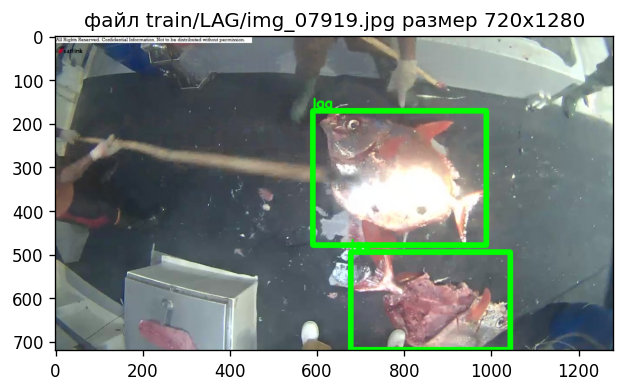

In [ ]:
from matplotlib import pyplot as plt

annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('файл {} размер {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

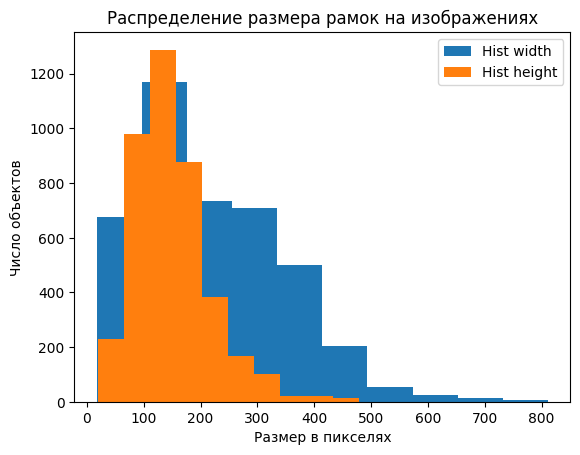

In [ ]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights)
plt.title('Распределение размера рамок на изображениях')
plt.legend(['Hist width','Hist height'], loc='upper right')
plt.xlabel('Размер в пикселях')
plt.ylabel('Число объектов')
plt.show()

# Экстрактор признаков

In [ ]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [ ]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
num_classes = counts.shape[0]
num_classes

6

In [ ]:
from scipy.special import softmax

def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        label = fish_classes == rect['class']

        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):

            label = np.empty(6)
            # заполняем предсказанные вероятности каждого из 6-и классов в поля 'label'
            label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(conf)
            label = softmax(label)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

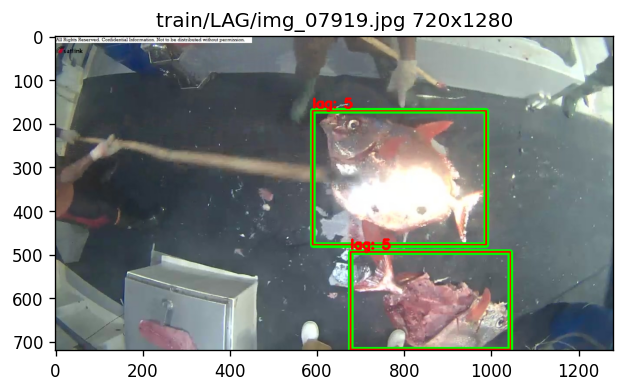

In [ ]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 6],
                                      y_pred[..., 6],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., -4:] - y_pred[..., -4:])
    square_loss = 0.5 * K.square(y_true[..., -4:] - y_pred[..., -4:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):

    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred)

    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy

    return tf.reduce_sum(loss, axis=-1)

def class_loss(y_tr, y_pr):

    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = K.categorical_crossentropy(y_true[..., :6],
                                               y_pred[..., :6],
                                               from_logits=True)

    return cross_entropy

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))

    # TODO: добавьте функцию потерь для классификации детекции
    cls_loss = classification_loss(y_true, y_pred)

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 6], axis=-1)
    pos_class_loss = K.sum(cls_loss * y_true[..., 6], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 6], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 6], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 6]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    cls_loss = pos_class_loss / (num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss + cls_loss

## Загрузка данных

In [ ]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y_ = encode_anchors(boxes[j], img_shape)
                y.append(y_)
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [ ]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции.
# Добавлено 6 выходов для классификации детекции 6-и классов (alb, bet, dol, lag, shark, yft).
# Вероятности классов 'Other Fishes' и 'No Fishes' возьмем из примера (sample_submission), они будут константами (не входят в выходы НС):
#  Oth: 0.079142
#  NoF: 0.123081

# Итого получилось 11 выходов:
# - 6 классов (вероятности каждого из классов, рассчитанные по функции sоftmax)
# - 2 координаты x,y верхнего левого угла распознанного изображения
# - 2 величины смещения (высота, ширина) от координат верхнего левого угла распознанного изображения
# - 1 вероятность наличия распознанного изображения на картинке (по функции сигмоиды)

output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 750, 1200, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 750, 1200, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 750, 1200, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 375, 600, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 375, 600, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 375, 600, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 187, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 187, 300, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 93, 150, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 93, 150, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 46, 75, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 23, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 23, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 23, 37, 11)          │           5,6

 Total params: 14,722,379 (56.16 MB)

 Trainable params: 7,086,091 (27.03 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

## Обучение

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=adam,
              loss=total_loss,
              metrics=[confidence_loss, classification_loss, smooth_l1])

In [ ]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
#steps_per_epoch = sum(map(len, boxes.values()), 0) // batch_size # так считает слишком долго, ускорим расчет
steps_per_epoch = 10 # ускорим расчет

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=2,
          callbacks=[checkpoint])

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 750, 1200, 3))
  warnings.warn(msg)


 9/10 ━━━━━━━━━━━━━━━━━━━━ 1:04 64s/step - classification_loss: 0.5803 - confidence_loss: 0.9068 - loss: 5.8595 - smooth_l1: 2.3181
Epoch 1: loss improved from inf to 5.00311, saving model to fishdetector.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 642s 64s/step - classification_loss: 0.5850 - confidence_loss: 0.9038 - loss: 5.7038 - smooth_l1: 2.3065
Epoch 2/2
 9/10 ━━━━━━━━━━━━━━━━━━━━ 1:04 64s/step - classification_loss: 0.5528 - confidence_loss: 0.8057 - loss: 3.1357 - smooth_l1: 1.6652
Epoch 2: loss improved from 5.00311 to 2.83991, saving model to fishdetector.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 639s 64s/step - classification_loss: 0.5424 - confidence_loss: 0.8015 - loss: 3.0819 - smooth_l1: 1.6351


## Результат работы детектора

In [ ]:
#model.load_weights('data/fish/fishdetector_weights.hdf5')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 750, 1200, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


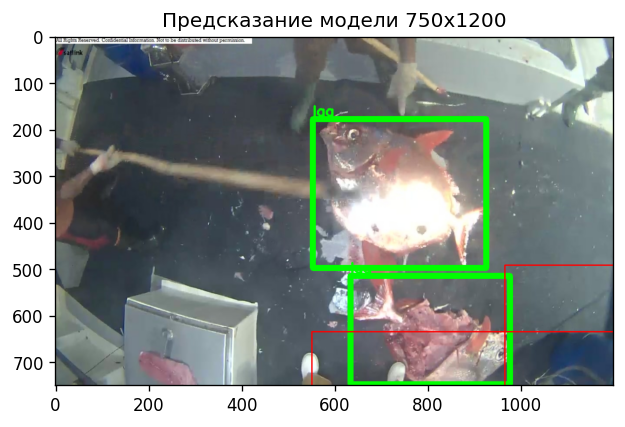

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.15)

decoded = non_max_suppression(decoded,
                              max_output_size=2,
                              iou_threshold=0.5)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


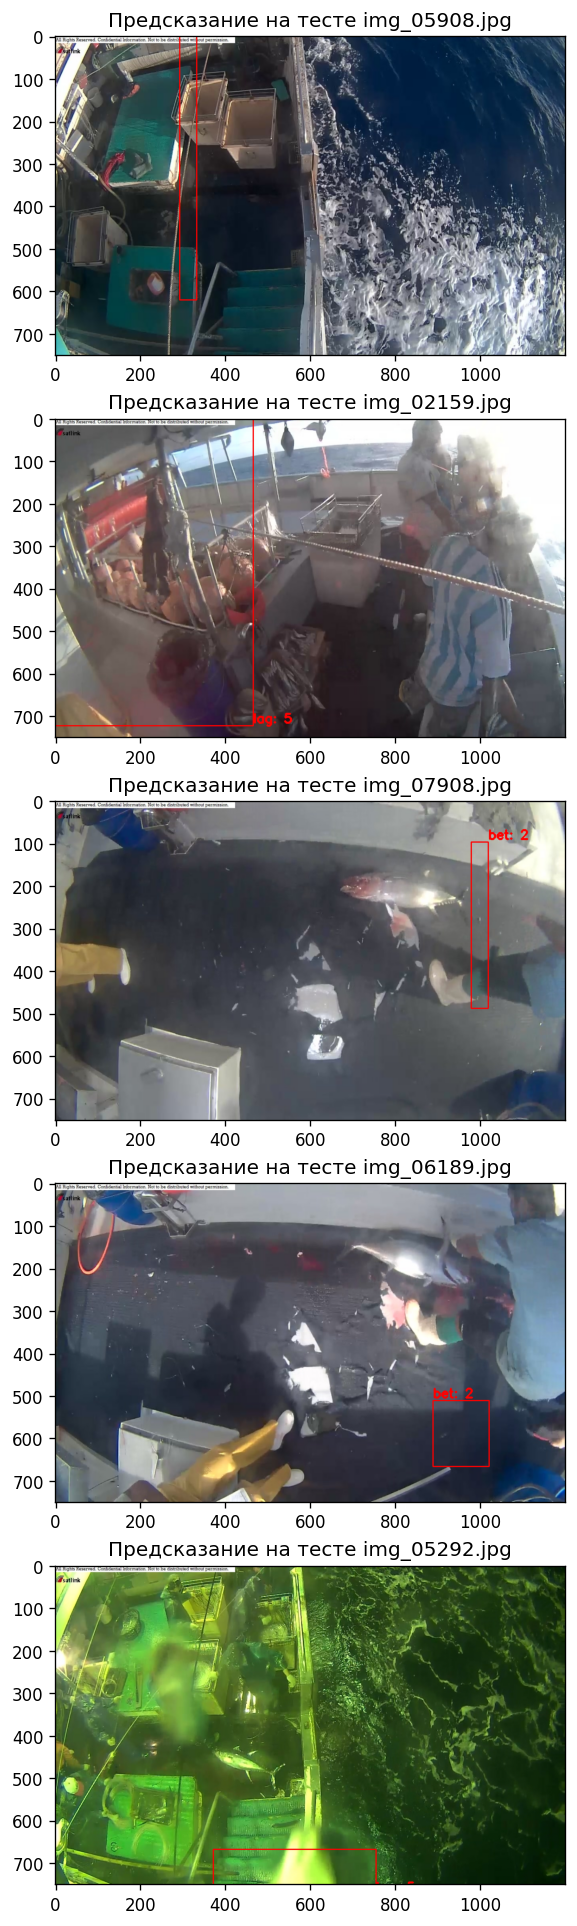

In [ ]:
test_images = glob('test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.01)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.5)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename.split('/')[-1]));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0

In [ ]:
fish_classes

array(['alb', 'yft', 'bet', 'shark', 'dol', 'lag'], dtype=object)

In [ ]:
from tqdm import tqdm

In [ ]:
def make_predictions():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])

    for i, file in enumerate(tqdm(glob('test_stg1/*.jpg'))):
        bn = os.path.basename(file)
        # print(bn)
        _, sample_img = load_img(file)

        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.01)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)

        decoded = decoded[0]['labels']

        ptable.loc[i, 'image'] = bn
        ptable.loc[i, 'ALB'] = decoded[0]
        ptable.loc[i, 'BET'] = decoded[2]
        ptable.loc[i, 'DOL'] = decoded[4]
        ptable.loc[i, 'LAG'] = decoded[5]
        ptable.loc[i, 'SHARK'] = decoded[3]
        ptable.loc[i, 'YFT'] = decoded[1]
        ptable.loc[i, 'NoF'] = 0.123081 # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
        ptable.loc[i, 'OTHER'] = 0.079142 # фиксированная вероятность для класса 'Other Fishes' из файла sample_submission

    i += 1

    for j, file in enumerate(tqdm(glob('test_stg2/*.jpg'))):
        bn = os.path.basename(file)

        bn = "test_stg2/" + bn

        _, sample_img = load_img(file)

        pred = model.predict(np.array([sample_img,]))[0]

        decoded = decode_prediction(pred, conf_thr=0.01)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)

        decoded = decoded[0]['labels']

        ptable.loc[i + j, 'image'] = bn
        ptable.loc[i + j, 'ALB'] = decoded[0]
        ptable.loc[i + j, 'BET'] = decoded[2]
        ptable.loc[i + j, 'DOL'] = decoded[4]
        ptable.loc[i + j, 'LAG'] = decoded[5]
        ptable.loc[i + j, 'SHARK'] = decoded[3]
        ptable.loc[i + j, 'YFT'] = decoded[1]

        ptable.loc[i + j, 'NoF'] = 0.123081 # фиксированная вероятность для класса 'No Fishes' из файла sample_submission
        ptable.loc[i + j, 'OTHER'] = 0.079142 # фиксированная вероятность для класса 'Other Fishes' из файла sample_submission

    return ptable

In [ ]:
pred_table = make_predictions()
pred_table.to_csv('submit.csv', index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 1/1000 [00:10<2:53:35, 10.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 2/1000 [00:21<3:02:42, 10.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 3/1000 [00:33<3:05:40, 11.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


  0%|          | 4/1000 [00:53<4:07:18, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  0%|          | 5/1000 [01:05<3:49:18, 13.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 6/1000 [01:26<4:27:12, 16.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 7/1000 [01:46<4:51:08, 17.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 8/1000 [02:07<5:06:39, 18.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 9/1000 [02:28<5:17:11, 19.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 10/1000 [02:39<4:37:08, 16.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  1%|          | 11/1000 [02:51<4:12:16, 15.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 12/1000 [03:01<3:47:41, 13.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 13/1000 [03:22<4:21:17, 15.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 14/1000 [03:34<3:59:06, 14.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 15/1000 [03:44<3:36:39, 13.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 16/1000 [03:55<3:25:22, 12.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 17/1000 [04:15<4:04:57, 14.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 18/1000 [04:36<4:32:29, 16.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 19/1000 [04:56<4:51:36, 17.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 20/1000 [05:17<5:04:51, 18.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 21/1000 [05:38<5:14:05, 19.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 22/1000 [05:58<5:20:31, 19.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  2%|▏         | 23/1000 [06:10<4:43:22, 17.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 24/1000 [06:22<4:14:20, 15.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▎         | 25/1000 [06:33<3:54:31, 14.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 26/1000 [06:54<4:24:25, 16.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 27/1000 [07:15<4:45:08, 17.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 28/1000 [07:26<4:14:33, 15.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 29/1000 [07:36<3:48:22, 14.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 30/1000 [07:47<3:31:26, 13.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 31/1000 [08:08<4:07:42, 15.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 32/1000 [08:18<3:44:59, 13.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 33/1000 [08:29<3:26:46, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 34/1000 [08:49<4:04:03, 15.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▎         | 35/1000 [09:10<4:30:08, 16.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▎         | 36/1000 [09:21<4:03:27, 15.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▎         | 37/1000 [09:33<3:45:19, 14.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▍         | 38/1000 [09:53<4:16:48, 16.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▍         | 39/1000 [10:04<3:51:54, 14.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▍         | 40/1000 [10:15<3:36:44, 13.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▍         | 41/1000 [10:36<4:10:33, 15.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  4%|▍         | 42/1000 [10:46<3:43:00, 13.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


  4%|▍         | 43/1000 [11:07<4:14:38, 15.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  4%|▍         | 44/1000 [11:27<4:36:34, 17.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  4%|▍         | 45/1000 [11:48<4:51:48, 18.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  5%|▍         | 46/1000 [12:09<5:02:21, 19.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  5%|▍         | 47/1000 [12:29<5:09:40, 19.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  5%|▍         | 48/1000 [12:41<4:31:18, 17.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  5%|▍         | 49/1000 [12:51<3:56:31, 14.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  5%|▌         | 50/1000 [13:11<4:23:28, 16.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  5%|▌         | 51/1000 [13:32<4:42:06, 17.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  5%|▌         | 52/1000 [13:42<4:06:21, 15.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  5%|▌         | 53/1000 [14:03<4:29:48, 17.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  5%|▌         | 54/1000 [14:23<4:46:09, 18.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  6%|▌         | 55/1000 [14:35<4:13:56, 16.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  6%|▌         | 56/1000 [14:46<3:51:48, 14.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  6%|▌         | 57/1000 [14:58<3:36:09, 13.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  6%|▌         | 58/1000 [15:08<3:20:02, 12.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  6%|▌         | 59/1000 [15:29<3:57:04, 15.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  6%|▌         | 60/1000 [15:49<4:22:36, 16.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  6%|▌         | 61/1000 [15:59<3:49:05, 14.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  6%|▌         | 62/1000 [16:11<3:35:57, 13.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  6%|▋         | 63/1000 [16:32<4:07:30, 15.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  6%|▋         | 64/1000 [16:42<3:41:37, 14.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  6%|▋         | 65/1000 [16:53<3:25:07, 13.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 66/1000 [17:13<3:59:38, 15.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 67/1000 [17:34<4:23:45, 16.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 68/1000 [17:45<3:57:43, 15.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 69/1000 [17:57<3:39:32, 14.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 70/1000 [18:08<3:26:51, 13.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  7%|▋         | 71/1000 [18:18<3:09:48, 12.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 72/1000 [18:29<3:05:28, 11.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 73/1000 [18:41<3:02:45, 11.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  7%|▋         | 74/1000 [18:52<3:00:48, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  8%|▊         | 75/1000 [19:03<2:54:49, 11.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  8%|▊         | 76/1000 [19:13<2:51:20, 11.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 77/1000 [19:25<2:52:20, 11.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 78/1000 [19:36<2:53:29, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 79/1000 [19:57<3:36:15, 14.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 80/1000 [20:17<4:05:59, 16.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 81/1000 [20:29<3:44:28, 14.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  8%|▊         | 82/1000 [20:39<3:22:00, 13.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 83/1000 [20:50<3:12:38, 12.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 84/1000 [21:10<3:49:04, 15.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  8%|▊         | 85/1000 [21:22<3:31:33, 13.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  9%|▊         | 86/1000 [21:32<3:17:09, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  9%|▊         | 87/1000 [21:44<3:12:25, 12.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  9%|▉         | 88/1000 [21:56<3:08:45, 12.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  9%|▉         | 89/1000 [22:08<3:04:05, 12.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  9%|▉         | 90/1000 [22:17<2:52:51, 11.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  9%|▉         | 91/1000 [22:38<3:34:43, 14.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  9%|▉         | 92/1000 [22:50<3:22:00, 13.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  9%|▉         | 93/1000 [23:00<3:08:00, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  9%|▉         | 94/1000 [23:20<3:44:58, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|▉         | 95/1000 [23:41<4:10:33, 16.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 10%|▉         | 96/1000 [23:51<3:42:06, 14.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|▉         | 97/1000 [24:02<3:24:08, 13.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|▉         | 98/1000 [24:14<3:14:12, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|▉         | 99/1000 [24:25<3:07:18, 12.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|█         | 100/1000 [24:36<3:00:05, 12.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 10%|█         | 101/1000 [24:46<2:51:42, 11.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|█         | 102/1000 [24:58<2:51:20, 11.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|█         | 103/1000 [25:09<2:51:20, 11.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|█         | 104/1000 [25:30<3:32:10, 14.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 10%|█         | 105/1000 [25:50<4:00:45, 16.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█         | 106/1000 [26:02<3:39:29, 14.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 11%|█         | 107/1000 [26:22<4:05:31, 16.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█         | 108/1000 [26:43<4:23:36, 17.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█         | 109/1000 [27:04<4:36:05, 18.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█         | 110/1000 [27:15<4:03:50, 16.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█         | 111/1000 [27:26<3:41:06, 14.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█         | 112/1000 [27:47<4:06:04, 16.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█▏        | 113/1000 [27:58<3:42:33, 15.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 11%|█▏        | 114/1000 [28:10<3:26:29, 13.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 115/1000 [28:21<3:14:55, 13.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 12%|█▏        | 116/1000 [28:32<3:02:11, 12.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 117/1000 [28:42<2:54:30, 11.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 118/1000 [28:54<2:52:23, 11.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 119/1000 [29:05<2:51:01, 11.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 120/1000 [29:26<3:30:13, 14.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 121/1000 [29:37<3:16:50, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 122/1000 [29:49<3:07:47, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 123/1000 [30:09<3:41:41, 15.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▏        | 124/1000 [30:21<3:24:59, 14.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 12%|█▎        | 125/1000 [30:32<3:13:20, 13.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 13%|█▎        | 126/1000 [30:44<3:05:11, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 13%|█▎        | 127/1000 [30:54<2:54:46, 12.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 13%|█▎        | 128/1000 [31:05<2:49:09, 11.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 13%|█▎        | 129/1000 [31:16<2:48:31, 11.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 13%|█▎        | 130/1000 [31:28<2:47:32, 11.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 13%|█▎        | 131/1000 [31:39<2:44:16, 11.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 13%|█▎        | 132/1000 [31:49<2:38:56, 10.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 13%|█▎        | 133/1000 [32:00<2:40:28, 11.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 13%|█▎        | 134/1000 [32:21<3:21:28, 13.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 14%|█▎        | 135/1000 [32:31<3:05:45, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▎        | 136/1000 [32:52<3:39:05, 15.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▎        | 137/1000 [33:03<3:22:28, 14.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▍        | 138/1000 [33:24<3:50:19, 16.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▍        | 139/1000 [33:35<3:29:52, 14.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▍        | 140/1000 [33:47<3:15:55, 13.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▍        | 141/1000 [34:07<3:45:32, 15.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▍        | 142/1000 [34:28<4:06:07, 17.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▍        | 143/1000 [34:39<3:40:55, 15.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 14%|█▍        | 144/1000 [34:50<3:18:52, 13.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 14%|█▍        | 145/1000 [35:00<3:04:57, 12.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 15%|█▍        | 146/1000 [35:12<2:58:10, 12.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 15%|█▍        | 147/1000 [35:23<2:53:17, 12.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 15%|█▍        | 148/1000 [35:35<2:50:40, 12.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 15%|█▍        | 149/1000 [35:44<2:40:44, 11.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 15%|█▌        | 150/1000 [35:56<2:40:48, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 15%|█▌        | 151/1000 [36:07<2:40:51, 11.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 15%|█▌        | 152/1000 [36:19<2:40:59, 11.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 15%|█▌        | 153/1000 [36:29<2:34:51, 10.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 15%|█▌        | 154/1000 [36:49<3:15:39, 13.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▌        | 155/1000 [37:10<3:43:59, 15.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 16%|█▌        | 156/1000 [37:20<3:20:35, 14.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▌        | 157/1000 [37:32<3:06:59, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▌        | 158/1000 [37:52<3:37:30, 15.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▌        | 159/1000 [38:13<3:58:40, 17.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▌        | 160/1000 [38:24<3:34:38, 15.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▌        | 161/1000 [38:45<3:56:31, 16.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 16%|█▌        | 162/1000 [38:55<3:29:00, 14.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▋        | 163/1000 [39:06<3:11:22, 13.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▋        | 164/1000 [39:27<3:39:53, 15.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 16%|█▋        | 165/1000 [39:37<3:18:29, 14.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 17%|█▋        | 166/1000 [39:48<3:02:07, 13.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 17%|█▋        | 167/1000 [39:59<2:54:46, 12.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 17%|█▋        | 168/1000 [40:20<3:27:52, 14.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 17%|█▋        | 169/1000 [40:29<3:05:28, 13.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 17%|█▋        | 170/1000 [40:41<2:56:53, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 17%|█▋        | 171/1000 [40:52<2:51:08, 12.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 17%|█▋        | 172/1000 [41:13<3:25:01, 14.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 17%|█▋        | 173/1000 [41:24<3:09:45, 13.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 17%|█▋        | 174/1000 [41:35<2:59:36, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 175/1000 [41:56<3:30:41, 15.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 176/1000 [42:07<3:11:38, 13.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 177/1000 [42:18<3:01:01, 13.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 178/1000 [42:39<3:31:19, 15.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 18%|█▊        | 179/1000 [42:49<3:10:34, 13.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 180/1000 [43:01<2:59:39, 13.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 181/1000 [43:21<3:29:56, 15.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 18%|█▊        | 182/1000 [43:31<3:09:11, 13.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 183/1000 [43:52<3:36:43, 15.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 184/1000 [44:04<3:17:59, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 18%|█▊        | 185/1000 [44:15<3:04:54, 13.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 19%|█▊        | 186/1000 [44:25<2:51:36, 12.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 19%|█▊        | 187/1000 [44:46<3:23:53, 15.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 19%|█▉        | 188/1000 [44:57<3:08:41, 13.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 19%|█▉        | 189/1000 [45:18<3:35:31, 15.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 19%|█▉        | 190/1000 [45:39<3:54:06, 17.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 19%|█▉        | 191/1000 [45:50<3:29:51, 15.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 19%|█▉        | 192/1000 [46:00<3:07:13, 13.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 19%|█▉        | 193/1000 [46:21<3:34:15, 15.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 19%|█▉        | 194/1000 [46:41<3:52:55, 17.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 20%|█▉        | 195/1000 [46:51<3:23:24, 15.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|█▉        | 196/1000 [47:12<3:45:11, 16.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|█▉        | 197/1000 [47:33<4:00:13, 17.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|█▉        | 198/1000 [47:44<3:32:48, 15.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|█▉        | 199/1000 [47:55<3:14:25, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|██        | 200/1000 [48:07<3:01:26, 13.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 20%|██        | 201/1000 [48:17<2:49:18, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 20%|██        | 202/1000 [48:28<2:40:00, 12.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|██        | 203/1000 [48:39<2:37:05, 11.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|██        | 204/1000 [48:50<2:35:11, 11.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 20%|██        | 205/1000 [49:02<2:33:50, 11.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 21%|██        | 206/1000 [49:12<2:26:01, 11.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 21%|██        | 207/1000 [49:32<3:03:57, 13.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 21%|██        | 208/1000 [49:53<3:30:18, 15.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 21%|██        | 209/1000 [50:03<3:07:11, 14.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 21%|██        | 210/1000 [50:24<3:32:15, 16.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 21%|██        | 211/1000 [50:44<3:49:42, 17.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 21%|██        | 212/1000 [50:56<3:25:31, 15.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 21%|██▏       | 213/1000 [51:07<3:08:20, 14.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 21%|██▏       | 214/1000 [51:18<2:56:17, 13.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 22%|██▏       | 215/1000 [51:29<2:44:07, 12.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 216/1000 [51:40<2:37:38, 12.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 217/1000 [51:51<2:34:51, 11.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 218/1000 [52:02<2:32:44, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 219/1000 [52:23<3:07:15, 14.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 220/1000 [52:34<2:55:12, 13.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 221/1000 [52:46<2:47:02, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 222/1000 [53:06<3:16:56, 15.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 223/1000 [53:18<3:01:46, 14.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 22%|██▏       | 224/1000 [53:38<3:27:00, 16.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 22%|██▎       | 225/1000 [53:49<3:05:20, 14.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 23%|██▎       | 226/1000 [53:59<2:50:11, 13.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 23%|██▎       | 227/1000 [54:11<2:42:48, 12.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 23%|██▎       | 228/1000 [54:22<2:37:51, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 23%|██▎       | 229/1000 [54:43<3:09:46, 14.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 23%|██▎       | 230/1000 [55:03<3:32:01, 16.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 23%|██▎       | 231/1000 [55:15<3:12:04, 14.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 23%|██▎       | 232/1000 [55:25<2:54:08, 13.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 23%|██▎       | 233/1000 [55:36<2:42:26, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 23%|██▎       | 234/1000 [55:56<3:12:32, 15.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▎       | 235/1000 [56:07<2:56:39, 13.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 24%|██▎       | 236/1000 [56:18<2:43:26, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▎       | 237/1000 [56:29<2:37:39, 12.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▍       | 238/1000 [56:41<2:33:37, 12.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▍       | 239/1000 [57:01<3:05:54, 14.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▍       | 240/1000 [57:22<3:28:26, 16.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▍       | 241/1000 [57:33<3:09:10, 14.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▍       | 242/1000 [57:44<2:52:54, 13.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 24%|██▍       | 243/1000 [57:54<2:40:21, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▍       | 244/1000 [58:06<2:35:16, 12.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 24%|██▍       | 245/1000 [58:26<3:06:20, 14.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 25%|██▍       | 246/1000 [58:36<2:46:43, 13.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 25%|██▍       | 247/1000 [58:57<3:14:21, 15.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 25%|██▍       | 248/1000 [59:08<2:58:43, 14.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 25%|██▍       | 249/1000 [59:29<3:22:17, 16.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 25%|██▌       | 250/1000 [59:41<3:06:57, 14.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 25%|██▌       | 251/1000 [59:52<2:53:30, 13.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 25%|██▌       | 252/1000 [1:00:13<3:18:23, 15.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 25%|██▌       | 253/1000 [1:00:24<3:01:27, 14.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 25%|██▌       | 254/1000 [1:00:45<3:23:45, 16.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 26%|██▌       | 255/1000 [1:00:55<3:00:38, 14.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▌       | 256/1000 [1:01:06<2:46:14, 13.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▌       | 257/1000 [1:01:18<2:38:41, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▌       | 258/1000 [1:01:29<2:33:17, 12.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▌       | 259/1000 [1:01:40<2:27:26, 11.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 26%|██▌       | 260/1000 [1:01:50<2:20:46, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▌       | 261/1000 [1:02:11<2:54:30, 14.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▌       | 262/1000 [1:02:22<2:44:13, 13.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 26%|██▋       | 263/1000 [1:02:32<2:30:24, 12.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▋       | 264/1000 [1:02:43<2:26:58, 11.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 26%|██▋       | 265/1000 [1:03:04<2:58:26, 14.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 27%|██▋       | 266/1000 [1:03:14<2:42:52, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 27%|██▋       | 267/1000 [1:03:25<2:32:45, 12.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 27%|██▋       | 268/1000 [1:03:36<2:28:26, 12.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 27%|██▋       | 269/1000 [1:03:47<2:25:32, 11.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 27%|██▋       | 270/1000 [1:03:58<2:21:47, 11.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 27%|██▋       | 271/1000 [1:04:09<2:17:14, 11.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 27%|██▋       | 272/1000 [1:04:30<2:50:59, 14.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 27%|██▋       | 273/1000 [1:04:50<3:14:31, 16.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 27%|██▋       | 274/1000 [1:05:11<3:30:55, 17.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 275/1000 [1:05:22<3:08:52, 15.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 28%|██▊       | 276/1000 [1:05:43<3:26:35, 17.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 277/1000 [1:06:03<3:38:52, 18.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 278/1000 [1:06:15<3:14:17, 16.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 28%|██▊       | 279/1000 [1:06:25<2:53:15, 14.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 280/1000 [1:06:46<3:15:27, 16.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 281/1000 [1:07:07<3:30:57, 17.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 28%|██▊       | 282/1000 [1:07:16<3:02:57, 15.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 283/1000 [1:07:28<2:48:38, 14.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 284/1000 [1:07:39<2:38:40, 13.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 28%|██▊       | 285/1000 [1:07:51<2:31:51, 12.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 29%|██▊       | 286/1000 [1:08:01<2:21:13, 11.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 29%|██▊       | 287/1000 [1:08:21<2:52:25, 14.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 29%|██▉       | 288/1000 [1:08:42<3:13:58, 16.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 29%|██▉       | 289/1000 [1:08:52<2:52:32, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 29%|██▉       | 290/1000 [1:09:13<3:13:48, 16.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 29%|██▉       | 291/1000 [1:09:33<3:28:30, 17.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 29%|██▉       | 292/1000 [1:09:54<3:38:41, 18.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 29%|██▉       | 293/1000 [1:10:05<3:13:11, 16.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 29%|██▉       | 294/1000 [1:10:16<2:51:42, 14.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|██▉       | 295/1000 [1:10:36<3:12:50, 16.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|██▉       | 296/1000 [1:10:57<3:27:22, 17.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 30%|██▉       | 297/1000 [1:11:07<3:01:27, 15.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|██▉       | 298/1000 [1:11:18<2:45:22, 14.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|██▉       | 299/1000 [1:11:30<2:35:32, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|███       | 300/1000 [1:11:50<3:00:57, 15.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 30%|███       | 301/1000 [1:12:01<2:42:54, 13.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|███       | 302/1000 [1:12:12<2:33:30, 13.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|███       | 303/1000 [1:12:24<2:27:15, 12.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 30%|███       | 304/1000 [1:12:35<2:22:22, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 30%|███       | 305/1000 [1:12:46<2:15:49, 11.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 31%|███       | 306/1000 [1:12:57<2:13:38, 11.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 31%|███       | 307/1000 [1:13:17<2:44:46, 14.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 31%|███       | 308/1000 [1:13:38<3:06:27, 16.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 31%|███       | 309/1000 [1:13:49<2:49:44, 14.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 31%|███       | 310/1000 [1:14:01<2:38:10, 13.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 31%|███       | 311/1000 [1:14:12<2:29:43, 13.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 31%|███       | 312/1000 [1:14:22<2:18:08, 12.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 31%|███▏      | 313/1000 [1:14:43<2:47:32, 14.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 31%|███▏      | 314/1000 [1:14:54<2:36:16, 13.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 32%|███▏      | 315/1000 [1:15:15<2:59:48, 15.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 316/1000 [1:15:35<3:16:10, 17.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 317/1000 [1:15:56<3:27:29, 18.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 318/1000 [1:16:16<3:35:17, 18.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 319/1000 [1:16:37<3:40:38, 19.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 320/1000 [1:16:58<3:44:15, 19.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 321/1000 [1:17:18<3:46:46, 20.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 322/1000 [1:17:29<3:16:04, 17.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 323/1000 [1:17:41<2:55:40, 15.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 32%|███▏      | 324/1000 [1:17:52<2:41:25, 14.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 32%|███▎      | 325/1000 [1:18:02<2:27:43, 13.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 33%|███▎      | 326/1000 [1:18:13<2:19:12, 12.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 33%|███▎      | 327/1000 [1:18:34<2:46:38, 14.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 33%|███▎      | 328/1000 [1:18:45<2:33:51, 13.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 33%|███▎      | 329/1000 [1:18:55<2:22:41, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 33%|███▎      | 330/1000 [1:19:07<2:17:53, 12.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 33%|███▎      | 331/1000 [1:19:27<2:45:17, 14.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 33%|███▎      | 332/1000 [1:19:48<3:04:22, 16.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 33%|███▎      | 333/1000 [1:19:59<2:46:59, 15.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 33%|███▎      | 334/1000 [1:20:11<2:34:41, 13.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 34%|███▎      | 335/1000 [1:20:22<2:26:16, 13.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 34%|███▎      | 336/1000 [1:20:32<2:14:16, 12.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 34%|███▎      | 337/1000 [1:20:52<2:42:12, 14.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 34%|███▍      | 338/1000 [1:21:04<2:31:10, 13.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 34%|███▍      | 339/1000 [1:21:14<2:19:59, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 34%|███▍      | 340/1000 [1:21:25<2:12:59, 12.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 34%|███▍      | 341/1000 [1:21:36<2:10:30, 11.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 34%|███▍      | 342/1000 [1:21:57<2:39:08, 14.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 34%|███▍      | 343/1000 [1:22:07<2:25:33, 13.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 34%|███▍      | 344/1000 [1:22:28<2:49:18, 15.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 34%|███▍      | 345/1000 [1:22:39<2:35:41, 14.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 35%|███▍      | 346/1000 [1:22:50<2:22:46, 13.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 35%|███▍      | 347/1000 [1:23:11<2:47:23, 15.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 35%|███▍      | 348/1000 [1:23:22<2:34:20, 14.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 35%|███▍      | 349/1000 [1:23:43<2:54:57, 16.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 35%|███▌      | 350/1000 [1:24:03<3:09:13, 17.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 35%|███▌      | 351/1000 [1:24:15<2:49:19, 15.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 35%|███▌      | 352/1000 [1:24:25<2:31:59, 14.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 35%|███▌      | 353/1000 [1:24:36<2:20:50, 13.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 35%|███▌      | 354/1000 [1:24:56<2:44:59, 15.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▌      | 355/1000 [1:25:17<3:01:44, 16.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▌      | 356/1000 [1:25:28<2:43:39, 15.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▌      | 357/1000 [1:25:40<2:31:22, 14.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▌      | 358/1000 [1:26:00<2:51:54, 16.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▌      | 359/1000 [1:26:12<2:36:33, 14.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▌      | 360/1000 [1:26:23<2:26:00, 13.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▌      | 361/1000 [1:26:35<2:18:38, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 36%|███▌      | 362/1000 [1:26:44<2:08:08, 12.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▋      | 363/1000 [1:27:05<2:35:24, 14.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▋      | 364/1000 [1:27:17<2:24:57, 13.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 36%|███▋      | 365/1000 [1:27:27<2:15:17, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 37%|███▋      | 366/1000 [1:27:48<2:40:01, 15.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 37%|███▋      | 367/1000 [1:27:59<2:28:00, 14.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 37%|███▋      | 368/1000 [1:28:20<2:48:40, 16.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 37%|███▋      | 369/1000 [1:28:31<2:33:22, 14.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 37%|███▋      | 370/1000 [1:28:52<2:52:09, 16.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 37%|███▋      | 371/1000 [1:29:02<2:32:38, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 37%|███▋      | 372/1000 [1:29:23<2:51:39, 16.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 37%|███▋      | 373/1000 [1:29:43<3:04:36, 17.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 37%|███▋      | 374/1000 [1:29:54<2:41:33, 15.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 375/1000 [1:30:14<2:57:27, 17.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 376/1000 [1:30:26<2:39:47, 15.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 377/1000 [1:30:37<2:26:25, 14.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 38%|███▊      | 378/1000 [1:30:48<2:14:48, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 379/1000 [1:31:08<2:38:22, 15.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 380/1000 [1:31:20<2:26:05, 14.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 38%|███▊      | 381/1000 [1:31:40<2:45:51, 16.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 382/1000 [1:32:01<2:59:36, 17.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 383/1000 [1:32:12<2:40:36, 15.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 38%|███▊      | 384/1000 [1:32:22<2:21:59, 13.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 38%|███▊      | 385/1000 [1:32:43<2:42:42, 15.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 39%|███▊      | 386/1000 [1:33:03<2:57:05, 17.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 39%|███▊      | 387/1000 [1:33:24<3:07:06, 18.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 39%|███▉      | 388/1000 [1:33:44<3:13:50, 19.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 39%|███▉      | 389/1000 [1:33:54<2:44:57, 16.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 39%|███▉      | 390/1000 [1:34:05<2:30:00, 14.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 39%|███▉      | 391/1000 [1:34:26<2:47:34, 16.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 39%|███▉      | 392/1000 [1:34:36<2:27:39, 14.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 39%|███▉      | 393/1000 [1:34:57<2:45:53, 16.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 39%|███▉      | 394/1000 [1:35:17<2:58:28, 17.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 40%|███▉      | 395/1000 [1:35:27<2:34:38, 15.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|███▉      | 396/1000 [1:35:48<2:50:16, 16.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|███▉      | 397/1000 [1:35:59<2:33:36, 15.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 40%|███▉      | 398/1000 [1:36:09<2:16:36, 13.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|███▉      | 399/1000 [1:36:20<2:09:15, 12.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|████      | 400/1000 [1:36:41<2:32:08, 15.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|████      | 401/1000 [1:36:52<2:18:14, 13.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 40%|████      | 402/1000 [1:37:02<2:07:42, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|████      | 403/1000 [1:37:23<2:30:45, 15.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|████      | 404/1000 [1:37:43<2:46:47, 16.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 40%|████      | 405/1000 [1:37:55<2:30:27, 15.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 41%|████      | 406/1000 [1:38:06<2:19:06, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 41%|████      | 407/1000 [1:38:18<2:11:08, 13.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 41%|████      | 408/1000 [1:38:27<2:00:32, 12.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 41%|████      | 409/1000 [1:38:39<1:57:34, 11.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 41%|████      | 410/1000 [1:38:50<1:55:53, 11.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 41%|████      | 411/1000 [1:39:11<2:21:43, 14.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 41%|████      | 412/1000 [1:39:21<2:10:11, 13.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 41%|████▏     | 413/1000 [1:39:42<2:31:26, 15.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 41%|████▏     | 414/1000 [1:39:53<2:17:43, 14.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 42%|████▏     | 415/1000 [1:40:03<2:06:46, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▏     | 416/1000 [1:40:24<2:28:46, 15.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▏     | 417/1000 [1:40:35<2:17:19, 14.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 42%|████▏     | 418/1000 [1:40:45<2:04:03, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▏     | 419/1000 [1:40:56<2:00:05, 12.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▏     | 420/1000 [1:41:17<2:23:39, 14.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 42%|████▏     | 421/1000 [1:41:27<2:10:25, 13.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 42%|████▏     | 422/1000 [1:41:38<2:01:52, 12.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▏     | 423/1000 [1:41:49<1:58:01, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▏     | 424/1000 [1:42:01<1:55:36, 12.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 42%|████▎     | 425/1000 [1:42:22<2:20:07, 14.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 43%|████▎     | 426/1000 [1:42:42<2:37:04, 16.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 43%|████▎     | 427/1000 [1:42:54<2:24:49, 15.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 43%|████▎     | 428/1000 [1:43:05<2:11:15, 13.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 43%|████▎     | 429/1000 [1:43:26<2:30:41, 15.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 43%|████▎     | 430/1000 [1:43:37<2:18:28, 14.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 43%|████▎     | 431/1000 [1:43:58<2:35:21, 16.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 43%|████▎     | 432/1000 [1:44:09<2:20:49, 14.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 43%|████▎     | 433/1000 [1:44:21<2:10:50, 13.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 43%|████▎     | 434/1000 [1:44:32<2:03:47, 13.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 44%|████▎     | 435/1000 [1:44:42<1:55:51, 12.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▎     | 436/1000 [1:44:53<1:51:43, 11.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▎     | 437/1000 [1:45:05<1:50:17, 11.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▍     | 438/1000 [1:45:25<2:15:04, 14.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 44%|████▍     | 439/1000 [1:45:36<2:03:38, 13.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▍     | 440/1000 [1:45:47<1:58:15, 12.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▍     | 441/1000 [1:46:08<2:20:17, 15.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 44%|████▍     | 442/1000 [1:46:18<2:07:00, 13.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▍     | 443/1000 [1:46:39<2:26:18, 15.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▍     | 444/1000 [1:46:50<2:14:00, 14.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 44%|████▍     | 445/1000 [1:47:02<2:05:23, 13.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 45%|████▍     | 446/1000 [1:47:12<1:56:24, 12.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 45%|████▍     | 447/1000 [1:47:23<1:51:05, 12.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 45%|████▍     | 448/1000 [1:47:44<2:14:29, 14.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 45%|████▍     | 449/1000 [1:48:04<2:30:45, 16.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 45%|████▌     | 450/1000 [1:48:15<2:16:33, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 45%|████▌     | 451/1000 [1:48:27<2:06:52, 13.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 45%|████▌     | 452/1000 [1:48:38<1:59:53, 13.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 45%|████▌     | 453/1000 [1:48:48<1:50:13, 12.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 45%|████▌     | 454/1000 [1:49:09<2:13:24, 14.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 46%|████▌     | 455/1000 [1:49:29<2:29:23, 16.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 46%|████▌     | 456/1000 [1:49:50<2:40:32, 17.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 46%|████▌     | 457/1000 [1:50:11<2:48:06, 18.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 46%|████▌     | 458/1000 [1:50:20<2:23:39, 15.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 46%|████▌     | 459/1000 [1:50:32<2:11:17, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 46%|████▌     | 460/1000 [1:50:52<2:27:23, 16.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 46%|████▌     | 461/1000 [1:51:03<2:10:57, 14.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 46%|████▌     | 462/1000 [1:51:13<2:00:09, 13.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 46%|████▋     | 463/1000 [1:51:25<1:54:41, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 46%|████▋     | 464/1000 [1:51:36<1:51:19, 12.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 46%|████▋     | 465/1000 [1:51:57<2:12:52, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 47%|████▋     | 466/1000 [1:52:08<2:03:11, 13.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 47%|████▋     | 467/1000 [1:52:29<2:20:58, 15.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 47%|████▋     | 468/1000 [1:52:39<2:06:06, 14.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 47%|████▋     | 469/1000 [1:53:00<2:22:55, 16.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 47%|████▋     | 470/1000 [1:53:21<2:34:30, 17.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 47%|████▋     | 471/1000 [1:53:30<2:13:54, 15.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 47%|████▋     | 472/1000 [1:53:51<2:28:07, 16.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 47%|████▋     | 473/1000 [1:54:03<2:13:42, 15.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 47%|████▋     | 474/1000 [1:54:13<2:01:21, 13.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 48%|████▊     | 475/1000 [1:54:24<1:52:07, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 48%|████▊     | 476/1000 [1:54:35<1:48:11, 12.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 48%|████▊     | 477/1000 [1:54:56<2:09:32, 14.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 48%|████▊     | 478/1000 [1:55:05<1:56:09, 13.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 48%|████▊     | 479/1000 [1:55:26<2:14:52, 15.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 48%|████▊     | 480/1000 [1:55:38<2:04:14, 14.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 48%|████▊     | 481/1000 [1:55:48<1:53:45, 13.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 48%|████▊     | 482/1000 [1:55:59<1:47:14, 12.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 48%|████▊     | 483/1000 [1:56:19<2:08:12, 14.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 48%|████▊     | 484/1000 [1:56:30<1:57:56, 13.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 48%|████▊     | 485/1000 [1:56:40<1:48:11, 12.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 49%|████▊     | 486/1000 [1:57:01<2:08:32, 15.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 49%|████▊     | 487/1000 [1:57:12<1:59:06, 13.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 49%|████▉     | 488/1000 [1:57:23<1:49:46, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 49%|████▉     | 489/1000 [1:57:43<2:09:25, 15.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 49%|████▉     | 490/1000 [1:58:04<2:22:56, 16.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 49%|████▉     | 491/1000 [1:58:14<2:04:21, 14.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 49%|████▉     | 492/1000 [1:58:34<2:19:15, 16.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 49%|████▉     | 493/1000 [1:58:46<2:06:12, 14.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 49%|████▉     | 494/1000 [1:58:56<1:54:01, 13.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|████▉     | 495/1000 [1:59:07<1:47:00, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|████▉     | 496/1000 [1:59:18<1:43:24, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|████▉     | 497/1000 [1:59:29<1:41:04, 12.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|████▉     | 498/1000 [1:59:40<1:37:56, 11.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 50%|████▉     | 499/1000 [1:59:51<1:33:54, 11.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|█████     | 500/1000 [2:00:02<1:34:19, 11.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|█████     | 501/1000 [2:00:13<1:34:21, 11.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|█████     | 502/1000 [2:00:25<1:34:28, 11.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 50%|█████     | 503/1000 [2:00:35<1:29:58, 10.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|█████     | 504/1000 [2:00:46<1:31:12, 11.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 50%|█████     | 505/1000 [2:00:57<1:32:09, 11.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████     | 506/1000 [2:01:18<1:55:19, 14.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████     | 507/1000 [2:01:29<1:47:18, 13.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████     | 508/1000 [2:01:40<1:43:01, 12.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████     | 509/1000 [2:01:52<1:40:04, 12.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████     | 510/1000 [2:02:12<2:00:24, 14.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████     | 511/1000 [2:02:33<2:14:28, 16.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████     | 512/1000 [2:02:54<2:24:13, 17.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████▏    | 513/1000 [2:03:14<2:30:55, 18.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 51%|█████▏    | 514/1000 [2:03:35<2:35:34, 19.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▏    | 515/1000 [2:03:46<2:16:16, 16.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▏    | 516/1000 [2:04:07<2:25:03, 17.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 52%|█████▏    | 517/1000 [2:04:17<2:06:01, 15.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▏    | 518/1000 [2:04:38<2:17:48, 17.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▏    | 519/1000 [2:04:58<2:25:49, 18.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 52%|█████▏    | 520/1000 [2:05:08<2:04:58, 15.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▏    | 521/1000 [2:05:19<1:54:33, 14.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▏    | 522/1000 [2:05:31<1:47:27, 13.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▏    | 523/1000 [2:05:42<1:42:16, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 52%|█████▏    | 524/1000 [2:05:53<1:36:10, 12.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 52%|█████▎    | 525/1000 [2:06:03<1:32:40, 11.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 53%|█████▎    | 526/1000 [2:06:15<1:31:43, 11.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 53%|█████▎    | 527/1000 [2:06:26<1:31:10, 11.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 53%|█████▎    | 528/1000 [2:06:37<1:29:07, 11.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 53%|█████▎    | 529/1000 [2:06:47<1:26:50, 11.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 53%|█████▎    | 530/1000 [2:06:59<1:27:31, 11.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 53%|█████▎    | 531/1000 [2:07:19<1:49:25, 14.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 53%|█████▎    | 532/1000 [2:07:29<1:39:13, 12.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 53%|█████▎    | 533/1000 [2:07:40<1:35:40, 12.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 53%|█████▎    | 534/1000 [2:08:01<1:54:51, 14.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 54%|█████▎    | 535/1000 [2:08:11<1:44:21, 13.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 54%|█████▎    | 536/1000 [2:08:22<1:37:27, 12.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 54%|█████▎    | 537/1000 [2:08:34<1:34:32, 12.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 54%|█████▍    | 538/1000 [2:08:54<1:53:41, 14.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 54%|█████▍    | 539/1000 [2:09:04<1:42:35, 13.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 54%|█████▍    | 540/1000 [2:09:25<1:59:06, 15.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 54%|█████▍    | 541/1000 [2:09:36<1:49:31, 14.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 54%|█████▍    | 542/1000 [2:09:47<1:40:16, 13.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 54%|█████▍    | 543/1000 [2:09:57<1:34:37, 12.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 54%|█████▍    | 544/1000 [2:10:18<1:53:03, 14.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 55%|█████▍    | 545/1000 [2:10:29<1:43:04, 13.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 55%|█████▍    | 546/1000 [2:10:39<1:35:41, 12.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 55%|█████▍    | 547/1000 [2:11:00<1:53:31, 15.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 55%|█████▍    | 548/1000 [2:11:20<2:05:52, 16.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 55%|█████▍    | 549/1000 [2:11:41<2:14:24, 17.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 55%|█████▌    | 550/1000 [2:11:52<1:59:30, 15.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 55%|█████▌    | 551/1000 [2:12:03<1:46:46, 14.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 55%|█████▌    | 552/1000 [2:12:13<1:38:24, 13.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 55%|█████▌    | 553/1000 [2:12:34<1:54:47, 15.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 55%|█████▌    | 554/1000 [2:12:55<2:06:08, 16.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▌    | 555/1000 [2:13:15<2:13:56, 18.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▌    | 556/1000 [2:13:27<1:58:53, 16.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 56%|█████▌    | 557/1000 [2:13:37<1:46:06, 14.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▌    | 558/1000 [2:13:58<1:59:46, 16.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▌    | 559/1000 [2:14:09<1:48:43, 14.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▌    | 560/1000 [2:14:30<2:01:16, 16.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▌    | 561/1000 [2:14:41<1:49:41, 14.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▌    | 562/1000 [2:15:02<2:01:43, 16.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 56%|█████▋    | 563/1000 [2:15:11<1:46:01, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▋    | 564/1000 [2:15:23<1:38:47, 13.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 56%|█████▋    | 565/1000 [2:15:34<1:33:53, 12.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 57%|█████▋    | 566/1000 [2:15:45<1:30:23, 12.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 57%|█████▋    | 567/1000 [2:15:56<1:25:29, 11.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 57%|█████▋    | 568/1000 [2:16:16<1:44:20, 14.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 57%|█████▋    | 569/1000 [2:16:28<1:37:35, 13.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 57%|█████▋    | 570/1000 [2:16:39<1:32:43, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 57%|█████▋    | 571/1000 [2:16:49<1:25:29, 11.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 57%|█████▋    | 572/1000 [2:17:00<1:24:08, 11.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 57%|█████▋    | 573/1000 [2:17:21<1:42:44, 14.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 57%|█████▋    | 574/1000 [2:17:32<1:34:30, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 57%|█████▊    | 575/1000 [2:17:42<1:28:08, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 576/1000 [2:17:54<1:25:37, 12.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 577/1000 [2:18:14<1:43:24, 14.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 58%|█████▊    | 578/1000 [2:18:25<1:34:09, 13.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 579/1000 [2:18:45<1:49:14, 15.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 580/1000 [2:18:57<1:40:21, 14.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 581/1000 [2:19:17<1:53:16, 16.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 582/1000 [2:19:38<2:02:10, 17.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 583/1000 [2:19:49<1:49:07, 15.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 58%|█████▊    | 584/1000 [2:19:59<1:36:27, 13.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 58%|█████▊    | 585/1000 [2:20:20<1:50:13, 15.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 59%|█████▊    | 586/1000 [2:20:40<1:59:41, 17.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 59%|█████▊    | 587/1000 [2:21:01<2:06:13, 18.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 59%|█████▉    | 588/1000 [2:21:12<1:51:34, 16.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 59%|█████▉    | 589/1000 [2:21:24<1:41:20, 14.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 59%|█████▉    | 590/1000 [2:21:33<1:30:41, 13.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 59%|█████▉    | 591/1000 [2:21:54<1:45:28, 15.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 59%|█████▉    | 592/1000 [2:22:06<1:37:06, 14.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 59%|█████▉    | 593/1000 [2:22:16<1:28:31, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 59%|█████▉    | 594/1000 [2:22:36<1:43:44, 15.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|█████▉    | 595/1000 [2:22:48<1:35:32, 14.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|█████▉    | 596/1000 [2:23:08<1:48:21, 16.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|█████▉    | 597/1000 [2:23:20<1:38:29, 14.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|█████▉    | 598/1000 [2:23:40<1:50:10, 16.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 60%|█████▉    | 599/1000 [2:23:51<1:37:47, 14.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|██████    | 600/1000 [2:24:11<1:49:36, 16.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|██████    | 601/1000 [2:24:23<1:39:17, 14.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|██████    | 602/1000 [2:24:43<1:50:20, 16.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|██████    | 603/1000 [2:25:04<1:57:56, 17.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|██████    | 604/1000 [2:25:25<2:03:10, 18.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 60%|██████    | 605/1000 [2:25:45<2:06:41, 19.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████    | 606/1000 [2:26:06<2:09:04, 19.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████    | 607/1000 [2:26:17<1:51:15, 16.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████    | 608/1000 [2:26:37<1:58:05, 18.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████    | 609/1000 [2:26:48<1:43:26, 15.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 61%|██████    | 610/1000 [2:26:58<1:32:21, 14.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████    | 611/1000 [2:27:19<1:44:33, 16.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████    | 612/1000 [2:27:40<1:52:59, 17.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████▏   | 613/1000 [2:28:00<1:58:46, 18.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 61%|██████▏   | 614/1000 [2:28:12<1:45:02, 16.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 62%|██████▏   | 615/1000 [2:28:21<1:32:13, 14.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 62%|██████▏   | 616/1000 [2:28:33<1:26:00, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 62%|██████▏   | 617/1000 [2:28:44<1:21:54, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 62%|██████▏   | 618/1000 [2:29:05<1:36:35, 15.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 62%|██████▏   | 619/1000 [2:29:25<1:46:46, 16.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 62%|██████▏   | 620/1000 [2:29:37<1:36:22, 15.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 62%|██████▏   | 621/1000 [2:29:57<1:46:18, 16.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 62%|██████▏   | 622/1000 [2:30:09<1:35:47, 15.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 62%|██████▏   | 623/1000 [2:30:29<1:45:42, 16.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 62%|██████▏   | 624/1000 [2:30:40<1:33:20, 14.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 62%|██████▎   | 625/1000 [2:31:01<1:43:53, 16.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 63%|██████▎   | 626/1000 [2:31:12<1:33:50, 15.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 63%|██████▎   | 627/1000 [2:31:23<1:26:49, 13.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 63%|██████▎   | 628/1000 [2:31:33<1:18:37, 12.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 63%|██████▎   | 629/1000 [2:31:44<1:16:06, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 63%|██████▎   | 630/1000 [2:32:05<1:31:14, 14.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 63%|██████▎   | 631/1000 [2:32:15<1:22:43, 13.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 63%|██████▎   | 632/1000 [2:32:36<1:35:45, 15.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 63%|██████▎   | 633/1000 [2:32:47<1:27:45, 14.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 63%|██████▎   | 634/1000 [2:33:08<1:38:59, 16.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▎   | 635/1000 [2:33:29<1:46:43, 17.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▎   | 636/1000 [2:33:49<1:52:00, 18.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▎   | 637/1000 [2:34:01<1:38:53, 16.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▍   | 638/1000 [2:34:12<1:29:40, 14.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▍   | 639/1000 [2:34:33<1:39:49, 16.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 64%|██████▍   | 640/1000 [2:34:53<1:46:53, 17.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▍   | 641/1000 [2:35:05<1:35:13, 15.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▍   | 642/1000 [2:35:16<1:26:50, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 64%|██████▍   | 643/1000 [2:35:27<1:19:11, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▍   | 644/1000 [2:35:47<1:32:05, 15.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 64%|██████▍   | 645/1000 [2:36:08<1:40:54, 17.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 65%|██████▍   | 646/1000 [2:36:18<1:28:08, 14.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 65%|██████▍   | 647/1000 [2:36:29<1:21:36, 13.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 65%|██████▍   | 648/1000 [2:36:50<1:33:14, 15.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 65%|██████▍   | 649/1000 [2:37:00<1:22:21, 14.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 65%|██████▌   | 650/1000 [2:37:20<1:33:40, 16.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 65%|██████▌   | 651/1000 [2:37:32<1:25:25, 14.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 65%|██████▌   | 652/1000 [2:37:43<1:18:27, 13.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 65%|██████▌   | 653/1000 [2:37:53<1:12:52, 12.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 65%|██████▌   | 654/1000 [2:38:14<1:26:32, 15.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▌   | 655/1000 [2:38:34<1:35:58, 16.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▌   | 656/1000 [2:38:55<1:42:24, 17.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▌   | 657/1000 [2:39:16<1:46:53, 18.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▌   | 658/1000 [2:39:36<1:49:54, 19.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▌   | 659/1000 [2:39:57<1:51:55, 19.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 66%|██████▌   | 660/1000 [2:40:07<1:35:51, 16.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▌   | 661/1000 [2:40:28<1:41:49, 18.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▌   | 662/1000 [2:40:49<1:45:53, 18.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▋   | 663/1000 [2:41:09<1:48:37, 19.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 66%|██████▋   | 664/1000 [2:41:21<1:34:58, 16.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 66%|██████▋   | 665/1000 [2:41:31<1:23:41, 14.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 666/1000 [2:41:42<1:16:16, 13.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 667/1000 [2:41:53<1:12:11, 13.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 668/1000 [2:42:14<1:24:39, 15.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 67%|██████▋   | 669/1000 [2:42:24<1:16:00, 13.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 670/1000 [2:42:35<1:11:52, 13.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 671/1000 [2:42:47<1:09:02, 12.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 672/1000 [2:43:07<1:21:59, 15.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 673/1000 [2:43:28<1:30:55, 16.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 67%|██████▋   | 674/1000 [2:43:49<1:37:04, 17.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 675/1000 [2:44:09<1:41:15, 18.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 676/1000 [2:44:21<1:29:09, 16.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 677/1000 [2:44:32<1:19:54, 14.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 68%|██████▊   | 678/1000 [2:44:42<1:12:02, 13.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 679/1000 [2:45:02<1:23:19, 15.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 680/1000 [2:45:14<1:16:26, 14.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 68%|██████▊   | 681/1000 [2:45:24<1:08:47, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 682/1000 [2:45:35<1:06:01, 12.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 683/1000 [2:45:56<1:18:45, 14.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 68%|██████▊   | 684/1000 [2:46:06<1:12:02, 13.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 68%|██████▊   | 685/1000 [2:46:17<1:06:41, 12.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 69%|██████▊   | 686/1000 [2:46:28<1:04:25, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 69%|██████▊   | 687/1000 [2:46:49<1:17:12, 14.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 69%|██████▉   | 688/1000 [2:46:58<1:09:00, 13.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 69%|██████▉   | 689/1000 [2:47:10<1:05:46, 12.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 69%|██████▉   | 690/1000 [2:47:30<1:17:50, 15.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 69%|██████▉   | 691/1000 [2:47:41<1:10:35, 13.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 69%|██████▉   | 692/1000 [2:47:52<1:05:35, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 69%|██████▉   | 693/1000 [2:48:03<1:03:21, 12.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 69%|██████▉   | 694/1000 [2:48:14<1:01:39, 12.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|██████▉   | 695/1000 [2:48:35<1:14:28, 14.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|██████▉   | 696/1000 [2:48:46<1:09:14, 13.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|██████▉   | 697/1000 [2:48:58<1:05:37, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|██████▉   | 698/1000 [2:49:09<1:03:00, 12.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 70%|██████▉   | 699/1000 [2:49:20<59:35, 11.88s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|███████   | 700/1000 [2:49:40<1:12:35, 14.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|███████   | 701/1000 [2:50:01<1:21:27, 16.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 70%|███████   | 702/1000 [2:50:11<1:12:17, 14.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|███████   | 703/1000 [2:50:32<1:21:07, 16.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|███████   | 704/1000 [2:50:43<1:13:32, 14.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 70%|███████   | 705/1000 [2:50:55<1:08:07, 13.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 71%|███████   | 706/1000 [2:51:05<1:01:47, 12.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 71%|███████   | 707/1000 [2:51:25<1:13:17, 15.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 71%|███████   | 708/1000 [2:51:37<1:07:53, 13.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 71%|███████   | 709/1000 [2:51:47<1:02:29, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 71%|███████   | 710/1000 [2:52:08<1:13:33, 15.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 71%|███████   | 711/1000 [2:52:28<1:21:04, 16.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 71%|███████   | 712/1000 [2:52:39<1:11:31, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 71%|███████▏  | 713/1000 [2:52:59<1:19:32, 16.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 71%|███████▏  | 714/1000 [2:53:20<1:24:56, 17.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 72%|███████▏  | 715/1000 [2:53:30<1:12:58, 15.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 72%|███████▏  | 716/1000 [2:53:41<1:07:11, 14.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 72%|███████▏  | 717/1000 [2:53:52<1:02:59, 13.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


 72%|███████▏  | 718/1000 [2:54:13<1:13:02, 15.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 72%|███████▏  | 719/1000 [2:54:34<1:19:58, 17.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 72%|███████▏  | 720/1000 [2:54:45<1:11:49, 15.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 72%|███████▏  | 721/1000 [2:55:06<1:18:52, 16.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 72%|███████▏  | 722/1000 [2:55:17<1:10:47, 15.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 72%|███████▏  | 723/1000 [2:55:38<1:17:54, 16.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 72%|███████▏  | 724/1000 [2:55:48<1:08:39, 14.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 72%|███████▎  | 725/1000 [2:55:59<1:02:46, 13.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 73%|███████▎  | 726/1000 [2:56:20<1:12:02, 15.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 73%|███████▎  | 727/1000 [2:56:30<1:04:34, 14.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 73%|███████▎  | 728/1000 [2:56:51<1:13:10, 16.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 73%|███████▎  | 729/1000 [2:57:11<1:18:59, 17.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 73%|███████▎  | 730/1000 [2:57:22<1:09:07, 15.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 73%|███████▎  | 731/1000 [2:57:33<1:02:37, 13.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 73%|███████▎  | 732/1000 [2:57:53<1:11:17, 15.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 73%|███████▎  | 733/1000 [2:58:04<1:04:16, 14.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 73%|███████▎  | 734/1000 [2:58:14<58:23, 13.17s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▎  | 735/1000 [2:58:35<1:08:00, 15.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▎  | 736/1000 [2:58:55<1:14:38, 16.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▎  | 737/1000 [2:59:16<1:19:08, 18.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▍  | 738/1000 [2:59:27<1:10:08, 16.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 74%|███████▍  | 739/1000 [2:59:38<1:02:28, 14.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▍  | 740/1000 [2:59:49<57:36, 13.29s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▍  | 741/1000 [3:00:09<1:06:51, 15.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▍  | 742/1000 [3:00:30<1:13:13, 17.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▍  | 743/1000 [3:00:51<1:17:33, 18.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▍  | 744/1000 [3:01:11<1:20:28, 18.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 74%|███████▍  | 745/1000 [3:01:23<1:10:36, 16.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 75%|███████▍  | 746/1000 [3:01:34<1:03:42, 15.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 75%|███████▍  | 747/1000 [3:01:45<58:54, 13.97s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 75%|███████▍  | 748/1000 [3:01:55<53:40, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 75%|███████▍  | 749/1000 [3:02:06<51:14, 12.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 75%|███████▌  | 750/1000 [3:02:18<50:02, 12.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 75%|███████▌  | 751/1000 [3:02:38<1:00:34, 14.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 75%|███████▌  | 752/1000 [3:02:59<1:07:50, 16.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 75%|███████▌  | 753/1000 [3:03:20<1:12:45, 17.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


 75%|███████▌  | 754/1000 [3:03:29<1:02:33, 15.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 76%|███████▌  | 755/1000 [3:03:50<1:08:51, 16.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 76%|███████▌  | 756/1000 [3:04:01<1:01:59, 15.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 76%|███████▌  | 757/1000 [3:04:12<56:00, 13.83s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 76%|███████▌  | 758/1000 [3:04:33<1:04:04, 15.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 76%|███████▌  | 759/1000 [3:04:44<58:31, 14.57s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 76%|███████▌  | 760/1000 [3:04:56<54:30, 13.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 76%|███████▌  | 761/1000 [3:05:06<50:24, 12.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 76%|███████▌  | 762/1000 [3:05:17<47:59, 12.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 76%|███████▋  | 763/1000 [3:05:28<47:00, 11.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 76%|███████▋  | 764/1000 [3:05:49<57:06, 14.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 76%|███████▋  | 765/1000 [3:05:59<52:01, 13.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 77%|███████▋  | 766/1000 [3:06:11<49:37, 12.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 77%|███████▋  | 767/1000 [3:06:31<58:38, 15.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 77%|███████▋  | 768/1000 [3:06:41<52:08, 13.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 77%|███████▋  | 769/1000 [3:07:02<1:00:10, 15.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 77%|███████▋  | 770/1000 [3:07:13<55:08, 14.38s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 77%|███████▋  | 771/1000 [3:07:23<50:06, 13.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 77%|███████▋  | 772/1000 [3:07:44<58:28, 15.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 77%|███████▋  | 773/1000 [3:07:55<53:43, 14.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 77%|███████▋  | 774/1000 [3:08:16<1:00:43, 16.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 775/1000 [3:08:27<55:07, 14.70s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 776/1000 [3:08:39<51:15, 13.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 777/1000 [3:08:59<58:41, 15.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 778/1000 [3:09:11<53:35, 14.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 779/1000 [3:09:22<49:57, 13.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 780/1000 [3:09:34<47:23, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 78%|███████▊  | 781/1000 [3:09:44<44:05, 12.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 782/1000 [3:09:55<42:36, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 783/1000 [3:10:06<42:05, 11.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 78%|███████▊  | 784/1000 [3:10:27<51:36, 14.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 78%|███████▊  | 785/1000 [3:10:37<47:12, 13.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 79%|███████▊  | 786/1000 [3:10:58<54:58, 15.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 79%|███████▊  | 787/1000 [3:11:19<1:00:15, 16.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 79%|███████▉  | 788/1000 [3:11:39<1:03:52, 18.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 79%|███████▉  | 789/1000 [3:11:51<56:31, 16.08s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 79%|███████▉  | 790/1000 [3:12:01<50:11, 14.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 79%|███████▉  | 791/1000 [3:12:22<56:34, 16.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 79%|███████▉  | 792/1000 [3:12:42<1:00:50, 17.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 79%|███████▉  | 793/1000 [3:12:53<53:08, 15.40s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 79%|███████▉  | 794/1000 [3:13:03<48:12, 14.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|███████▉  | 795/1000 [3:13:24<54:42, 16.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 80%|███████▉  | 796/1000 [3:13:45<59:07, 17.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|███████▉  | 797/1000 [3:14:05<1:02:05, 18.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|███████▉  | 798/1000 [3:14:26<1:04:03, 19.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|███████▉  | 799/1000 [3:14:46<1:05:19, 19.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|████████  | 800/1000 [3:15:07<1:06:08, 19.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|████████  | 801/1000 [3:15:28<1:06:38, 20.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|████████  | 802/1000 [3:15:39<57:52, 17.54s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 80%|████████  | 803/1000 [3:16:00<1:00:36, 18.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|████████  | 804/1000 [3:16:11<53:22, 16.34s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 80%|████████  | 805/1000 [3:16:32<57:15, 17.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 81%|████████  | 806/1000 [3:16:42<49:15, 15.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 81%|████████  | 807/1000 [3:16:53<45:16, 14.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 81%|████████  | 808/1000 [3:17:04<42:26, 13.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 81%|████████  | 809/1000 [3:17:16<40:30, 12.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 81%|████████  | 810/1000 [3:17:26<38:04, 12.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 81%|████████  | 811/1000 [3:17:47<46:03, 14.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 81%|████████  | 812/1000 [3:18:07<51:26, 16.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 81%|████████▏ | 813/1000 [3:18:18<45:32, 14.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 81%|████████▏ | 814/1000 [3:18:29<41:46, 13.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 815/1000 [3:18:49<48:09, 15.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 816/1000 [3:19:10<52:29, 17.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 817/1000 [3:19:31<55:23, 18.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 818/1000 [3:19:51<57:19, 18.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 819/1000 [3:20:12<58:33, 19.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 820/1000 [3:20:32<59:18, 19.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 821/1000 [3:20:44<51:32, 17.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▏ | 822/1000 [3:21:04<54:12, 18.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 82%|████████▏ | 823/1000 [3:21:15<46:55, 15.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 82%|████████▏ | 824/1000 [3:21:25<42:02, 14.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 82%|████████▎ | 825/1000 [3:21:46<47:17, 16.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 826/1000 [3:22:07<50:50, 17.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 827/1000 [3:22:18<45:14, 15.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 828/1000 [3:22:29<41:17, 14.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 829/1000 [3:22:41<38:30, 13.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 83%|████████▎ | 830/1000 [3:22:51<35:01, 12.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 831/1000 [3:23:11<41:47, 14.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 832/1000 [3:23:32<46:24, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 833/1000 [3:23:43<41:18, 14.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 83%|████████▎ | 834/1000 [3:24:03<45:52, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▎ | 835/1000 [3:24:14<40:44, 14.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 84%|████████▎ | 836/1000 [3:24:24<36:48, 13.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▎ | 837/1000 [3:24:45<42:24, 15.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▍ | 838/1000 [3:25:06<46:11, 17.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▍ | 839/1000 [3:25:17<41:19, 15.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▍ | 840/1000 [3:25:28<37:52, 14.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▍ | 841/1000 [3:25:40<35:27, 13.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 84%|████████▍ | 842/1000 [3:25:50<32:24, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▍ | 843/1000 [3:26:10<38:45, 14.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 84%|████████▍ | 844/1000 [3:26:31<43:02, 16.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 84%|████████▍ | 845/1000 [3:26:41<38:06, 14.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 85%|████████▍ | 846/1000 [3:27:02<42:22, 16.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 85%|████████▍ | 847/1000 [3:27:23<45:13, 17.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 85%|████████▍ | 848/1000 [3:27:34<40:05, 15.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 85%|████████▍ | 849/1000 [3:27:46<36:34, 14.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 85%|████████▌ | 850/1000 [3:27:57<34:00, 13.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 85%|████████▌ | 851/1000 [3:28:07<31:23, 12.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 85%|████████▌ | 852/1000 [3:28:18<29:43, 12.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 85%|████████▌ | 853/1000 [3:28:29<29:01, 11.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 85%|████████▌ | 854/1000 [3:28:41<28:31, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▌ | 855/1000 [3:29:01<34:47, 14.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▌ | 856/1000 [3:29:22<39:01, 16.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▌ | 857/1000 [3:29:43<41:51, 17.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▌ | 858/1000 [3:30:03<43:43, 18.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▌ | 859/1000 [3:30:25<46:00, 19.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 86%|████████▌ | 860/1000 [3:30:36<39:18, 16.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▌ | 861/1000 [3:30:56<41:38, 17.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▌ | 862/1000 [3:31:17<43:10, 18.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▋ | 863/1000 [3:31:28<37:47, 16.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▋ | 864/1000 [3:31:40<34:01, 15.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 86%|████████▋ | 865/1000 [3:31:51<31:22, 13.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 87%|████████▋ | 866/1000 [3:32:02<28:45, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 87%|████████▋ | 867/1000 [3:32:22<33:44, 15.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 87%|████████▋ | 868/1000 [3:32:43<37:02, 16.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 87%|████████▋ | 869/1000 [3:32:53<32:32, 14.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 87%|████████▋ | 870/1000 [3:33:04<29:33, 13.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 87%|████████▋ | 871/1000 [3:33:16<27:52, 12.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 87%|████████▋ | 872/1000 [3:33:27<26:39, 12.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 87%|████████▋ | 873/1000 [3:33:48<31:36, 14.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 87%|████████▋ | 874/1000 [3:33:59<29:06, 13.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 88%|████████▊ | 875/1000 [3:34:10<27:20, 13.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 88%|████████▊ | 876/1000 [3:34:22<26:06, 12.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 88%|████████▊ | 877/1000 [3:34:32<24:06, 11.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 88%|████████▊ | 878/1000 [3:34:52<29:21, 14.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 88%|████████▊ | 879/1000 [3:35:04<27:17, 13.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 88%|████████▊ | 880/1000 [3:35:14<25:19, 12.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 88%|████████▊ | 881/1000 [3:35:25<23:46, 11.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 88%|████████▊ | 882/1000 [3:35:36<23:12, 11.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 88%|████████▊ | 883/1000 [3:35:57<28:11, 14.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 88%|████████▊ | 884/1000 [3:36:06<25:10, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 88%|████████▊ | 885/1000 [3:36:27<29:18, 15.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 89%|████████▊ | 886/1000 [3:36:48<32:05, 16.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 89%|████████▊ | 887/1000 [3:37:08<33:55, 18.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 89%|████████▉ | 888/1000 [3:37:20<29:57, 16.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 89%|████████▉ | 889/1000 [3:37:30<26:35, 14.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 89%|████████▉ | 890/1000 [3:37:51<29:49, 16.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 89%|████████▉ | 891/1000 [3:38:02<26:54, 14.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 89%|████████▉ | 892/1000 [3:38:14<24:50, 13.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 89%|████████▉ | 893/1000 [3:38:24<22:47, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 89%|████████▉ | 894/1000 [3:38:35<21:26, 12.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|████████▉ | 895/1000 [3:38:55<25:41, 14.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|████████▉ | 896/1000 [3:39:16<28:31, 16.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|████████▉ | 897/1000 [3:39:37<30:23, 17.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|████████▉ | 898/1000 [3:39:57<31:35, 18.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|████████▉ | 899/1000 [3:40:09<27:40, 16.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|█████████ | 900/1000 [3:40:29<29:28, 17.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 90%|█████████ | 901/1000 [3:40:39<25:20, 15.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|█████████ | 902/1000 [3:41:00<27:41, 16.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|█████████ | 903/1000 [3:41:11<24:45, 15.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|█████████ | 904/1000 [3:41:32<27:02, 16.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 90%|█████████ | 905/1000 [3:41:53<28:31, 18.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 91%|█████████ | 906/1000 [3:42:13<29:26, 18.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 91%|█████████ | 907/1000 [3:42:25<25:41, 16.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 91%|█████████ | 908/1000 [3:42:45<27:16, 17.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 91%|█████████ | 909/1000 [3:42:56<23:37, 15.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 91%|█████████ | 910/1000 [3:43:16<25:39, 17.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 91%|█████████ | 911/1000 [3:43:28<22:51, 15.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 91%|█████████ | 912/1000 [3:43:39<20:51, 14.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 91%|█████████▏| 913/1000 [3:43:49<18:41, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 91%|█████████▏| 914/1000 [3:44:00<17:50, 12.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 915/1000 [3:44:12<17:11, 12.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 916/1000 [3:44:32<20:33, 14.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 917/1000 [3:44:43<18:42, 13.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 918/1000 [3:44:55<17:36, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 919/1000 [3:45:06<16:48, 12.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 920/1000 [3:45:27<19:51, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 921/1000 [3:45:38<18:12, 13.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 922/1000 [3:45:49<17:03, 13.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▏| 923/1000 [3:46:01<16:12, 12.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 92%|█████████▏| 924/1000 [3:46:11<14:54, 11.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 92%|█████████▎| 925/1000 [3:46:31<18:02, 14.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 93%|█████████▎| 926/1000 [3:46:43<16:42, 13.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 93%|█████████▎| 927/1000 [3:46:53<15:19, 12.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 93%|█████████▎| 928/1000 [3:47:04<14:25, 12.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 93%|█████████▎| 929/1000 [3:47:15<14:00, 11.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 93%|█████████▎| 930/1000 [3:47:27<13:40, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 93%|█████████▎| 931/1000 [3:47:37<13:09, 11.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 93%|█████████▎| 932/1000 [3:47:48<12:34, 11.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 93%|█████████▎| 933/1000 [3:47:59<12:30, 11.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 93%|█████████▎| 934/1000 [3:48:11<12:22, 11.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 94%|█████████▎| 935/1000 [3:48:22<12:13, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 94%|█████████▎| 936/1000 [3:48:32<11:32, 10.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 94%|█████████▎| 937/1000 [3:48:52<14:27, 13.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 94%|█████████▍| 938/1000 [3:49:04<13:30, 13.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 94%|█████████▍| 939/1000 [3:49:14<12:28, 12.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 94%|█████████▍| 940/1000 [3:49:35<14:47, 14.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 94%|█████████▍| 941/1000 [3:49:55<16:15, 16.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 94%|█████████▍| 942/1000 [3:50:06<14:11, 14.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 94%|█████████▍| 943/1000 [3:50:17<12:49, 13.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 94%|█████████▍| 944/1000 [3:50:28<12:01, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 94%|█████████▍| 945/1000 [3:50:39<11:24, 12.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▍| 946/1000 [3:51:00<13:24, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▍| 947/1000 [3:51:21<14:40, 16.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▍| 948/1000 [3:51:41<15:26, 17.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▍| 949/1000 [3:51:53<13:30, 15.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▌| 950/1000 [3:52:04<12:07, 14.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▌| 951/1000 [3:52:16<11:07, 13.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 95%|█████████▌| 952/1000 [3:52:25<09:59, 12.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▌| 953/1000 [3:52:46<11:42, 14.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 95%|█████████▌| 954/1000 [3:53:07<12:45, 16.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 96%|█████████▌| 955/1000 [3:53:17<11:04, 14.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 96%|█████████▌| 956/1000 [3:53:28<10:05, 13.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 96%|█████████▌| 957/1000 [3:53:40<09:20, 13.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 96%|█████████▌| 958/1000 [3:53:51<08:42, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 96%|█████████▌| 959/1000 [3:54:01<08:05, 11.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 96%|█████████▌| 960/1000 [3:54:13<07:48, 11.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 96%|█████████▌| 961/1000 [3:54:33<09:20, 14.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 96%|█████████▌| 962/1000 [3:54:43<08:15, 13.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 96%|█████████▋| 963/1000 [3:55:04<09:26, 15.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 96%|█████████▋| 964/1000 [3:55:25<10:08, 16.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 96%|█████████▋| 965/1000 [3:55:35<08:44, 14.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 97%|█████████▋| 966/1000 [3:55:47<07:54, 13.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 97%|█████████▋| 967/1000 [3:55:58<07:15, 13.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 97%|█████████▋| 968/1000 [3:56:19<08:13, 15.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 97%|█████████▋| 969/1000 [3:56:29<07:13, 13.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 97%|█████████▋| 970/1000 [3:56:41<06:36, 13.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 97%|█████████▋| 971/1000 [3:57:01<07:27, 15.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 97%|█████████▋| 972/1000 [3:57:12<06:30, 13.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 97%|█████████▋| 973/1000 [3:57:23<05:56, 13.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 97%|█████████▋| 974/1000 [3:57:35<05:28, 12.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 975/1000 [3:57:55<06:16, 15.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 976/1000 [3:58:06<05:32, 13.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 977/1000 [3:58:18<05:02, 13.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 978/1000 [3:58:38<05:38, 15.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 98%|█████████▊| 979/1000 [3:58:59<05:56, 16.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 980/1000 [3:59:10<05:05, 15.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 981/1000 [3:59:22<04:28, 14.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 98%|█████████▊| 982/1000 [3:59:32<03:54, 13.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 98%|█████████▊| 983/1000 [3:59:53<04:20, 15.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 984/1000 [4:00:04<03:46, 14.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 98%|█████████▊| 985/1000 [4:00:25<04:01, 16.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▊| 986/1000 [4:00:46<04:04, 17.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▊| 987/1000 [4:01:06<03:59, 18.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▉| 988/1000 [4:01:18<03:15, 16.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▉| 989/1000 [4:01:29<02:43, 14.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▉| 990/1000 [4:01:50<02:45, 16.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▉| 991/1000 [4:02:01<02:14, 14.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▉| 992/1000 [4:02:21<02:13, 16.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


 99%|█████████▉| 993/1000 [4:02:32<01:44, 14.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


 99%|█████████▉| 994/1000 [4:02:43<01:21, 13.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


100%|█████████▉| 995/1000 [4:03:03<01:18, 15.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


100%|█████████▉| 996/1000 [4:03:24<01:08, 17.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


100%|█████████▉| 997/1000 [4:03:35<00:46, 15.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


100%|█████████▉| 998/1000 [4:03:47<00:28, 14.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


100%|█████████▉| 999/1000 [4:04:07<00:16, 16.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 0/12153 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 1/12153 [00:20<69:34:39, 20.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 2/12153 [00:30<48:46:13, 14.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 3/12153 [00:41<43:11:10, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 4/12153 [01:02<53:36:15, 15.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 5/12153 [01:22<59:22:59, 17.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 6/12153 [01:34<52:14:46, 15.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 7/12153 [01:45<47:44:28, 14.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 8/12153 [01:57<44:47:13, 13.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 9/12153 [02:06<41:07:33, 12.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 10/12153 [02:18<40:11:50, 11.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 11/12153 [02:29<39:40:00, 11.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 12/12153 [02:40<39:15:43, 11.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 13/12153 [02:51<37:57:18, 11.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 14/12153 [03:01<37:20:40, 11.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 15/12153 [03:22<47:02:28, 13.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 16/12153 [03:33<43:54:02, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 17/12153 [03:43<41:15:13, 12.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 18/12153 [04:04<49:44:13, 14.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 19/12153 [04:25<55:39:09, 16.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 20/12153 [04:36<50:30:49, 14.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 21/12153 [04:57<56:11:46, 16.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 22/12153 [05:06<49:09:39, 14.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 23/12153 [05:18<45:45:15, 13.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 24/12153 [05:38<52:51:56, 15.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 25/12153 [05:49<47:43:07, 14.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 26/12153 [05:59<43:55:40, 13.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 27/12153 [06:20<51:34:34, 15.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 28/12153 [06:31<47:34:37, 14.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


  0%|          | 29/12153 [06:41<43:05:36, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 30/12153 [07:01<50:58:53, 15.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 31/12153 [07:13<47:12:08, 14.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 32/12153 [07:23<43:01:39, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 33/12153 [07:34<41:19:11, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 34/12153 [07:54<49:43:41, 14.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 35/12153 [08:15<55:39:11, 16.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 36/12153 [08:26<50:25:28, 14.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 37/12153 [08:38<46:52:09, 13.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 38/12153 [08:59<53:37:09, 15.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 39/12153 [09:10<49:02:34, 14.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 40/12153 [09:31<55:07:47, 16.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 41/12153 [09:41<49:05:23, 14.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 42/12153 [09:52<45:02:04, 13.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 43/12153 [10:12<52:19:21, 15.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 44/12153 [10:33<57:26:03, 17.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 45/12153 [10:53<60:59:32, 18.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 46/12153 [11:05<54:11:20, 16.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 47/12153 [11:15<48:24:07, 14.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 48/12153 [11:26<44:46:08, 13.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 49/12153 [11:37<42:52:18, 12.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 50/12153 [11:58<50:49:32, 15.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 51/12153 [12:08<45:28:49, 13.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 52/12153 [12:19<43:19:48, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 53/12153 [12:31<41:51:15, 12.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 54/12153 [12:42<40:47:31, 12.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 55/12153 [12:52<38:17:43, 11.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 56/12153 [13:03<38:13:56, 11.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 57/12153 [13:24<47:31:46, 14.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 58/12153 [13:34<43:49:13, 13.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  0%|          | 59/12153 [13:55<51:29:54, 15.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  0%|          | 60/12153 [14:15<56:48:42, 16.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


  1%|          | 61/12153 [14:26<50:13:42, 14.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 62/12153 [14:46<55:57:22, 16.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 63/12153 [15:07<59:55:23, 17.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 64/12153 [15:17<52:24:40, 15.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 65/12153 [15:28<47:24:50, 14.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 66/12153 [15:40<44:46:59, 13.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 67/12153 [15:51<42:49:36, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 68/12153 [16:02<40:58:47, 12.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 69/12153 [16:12<38:52:55, 11.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 70/12153 [16:23<38:39:27, 11.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 71/12153 [16:44<47:49:43, 14.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


  1%|          | 72/12153 [16:54<43:10:21, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 73/12153 [17:14<50:59:28, 15.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 74/12153 [17:26<47:09:16, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 75/12153 [17:36<43:15:44, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 76/12153 [17:47<41:09:46, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 77/12153 [17:58<40:14:18, 12.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 78/12153 [18:10<39:41:53, 11.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 79/12153 [18:30<48:31:52, 14.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 80/12153 [18:51<54:41:56, 16.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 81/12153 [19:02<49:46:34, 14.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


  1%|          | 82/12153 [19:12<44:30:30, 13.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 83/12153 [19:32<51:54:35, 15.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 84/12153 [19:53<57:05:42, 17.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 85/12153 [20:04<51:12:26, 15.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 86/12153 [20:16<47:16:11, 14.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 87/12153 [20:36<53:50:05, 16.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 88/12153 [20:47<48:20:39, 14.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 89/12153 [21:07<54:33:27, 16.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 90/12153 [21:18<49:03:32, 14.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 91/12153 [21:29<44:49:36, 13.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 92/12153 [21:40<42:49:18, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 93/12153 [22:01<50:41:02, 15.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 94/12153 [22:10<45:18:58, 13.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 95/12153 [22:22<43:04:12, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 96/12153 [22:33<41:40:27, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 97/12153 [22:54<49:53:30, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 98/12153 [23:15<55:39:52, 16.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 99/12153 [23:35<59:41:27, 17.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


  1%|          | 100/12153 [23:45<51:26:55, 15.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 101/12153 [24:05<56:42:49, 16.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 102/12153 [24:26<60:27:17, 18.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


  1%|          | 103/12153 [24:41<57:06:51, 17.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


  1%|          | 104/12153 [24:56<54:48:50, 16.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 105/12153 [25:10<53:01:41, 15.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 106/12153 [25:24<50:52:54, 15.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


  1%|          | 107/12153 [25:45<56:23:53, 16.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 108/12153 [25:59<54:01:04, 16.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 109/12153 [26:14<52:26:08, 15.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


  1%|          | 110/12153 [26:27<50:12:23, 15.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 111/12153 [26:41<49:02:40, 14.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


  1%|          | 112/12153 [27:02<55:04:18, 16.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 113/12153 [27:12<48:48:03, 14.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 114/12153 [27:33<54:53:08, 16.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 115/12153 [27:53<59:05:36, 17.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 116/12153 [28:03<51:02:49, 15.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 117/12153 [28:23<56:24:30, 16.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 118/12153 [28:44<60:10:06, 18.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 119/12153 [29:05<62:49:26, 18.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 120/12153 [29:16<55:22:51, 16.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 121/12153 [29:37<59:25:07, 17.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 122/12153 [29:48<53:00:43, 15.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 123/12153 [30:09<57:46:56, 17.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 124/12153 [30:18<50:08:09, 15.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 125/12153 [30:39<55:44:48, 16.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 126/12153 [31:00<59:41:36, 17.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 127/12153 [31:10<52:33:43, 15.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 128/12153 [31:31<57:26:31, 17.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 129/12153 [31:52<60:51:14, 18.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 130/12153 [32:12<63:16:13, 18.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 131/12153 [32:24<55:42:13, 16.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 132/12153 [32:33<48:43:18, 14.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 133/12153 [32:45<45:30:03, 13.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 134/12153 [33:05<52:29:22, 15.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 135/12153 [33:16<47:06:46, 14.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 136/12153 [33:26<43:38:11, 13.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 137/12153 [33:47<51:10:59, 15.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 138/12153 [33:58<46:43:19, 14.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 139/12153 [34:08<43:07:51, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 140/12153 [34:29<50:49:40, 15.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 141/12153 [34:49<56:12:40, 16.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 142/12153 [35:01<50:43:36, 15.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 143/12153 [35:12<46:58:00, 14.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 144/12153 [35:24<44:21:14, 13.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|          | 145/12153 [35:34<41:17:02, 12.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 146/12153 [35:45<39:42:13, 11.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 147/12153 [35:56<39:08:23, 11.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 148/12153 [36:08<38:49:36, 11.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 149/12153 [36:28<47:46:56, 14.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 150/12153 [36:49<54:03:39, 16.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|          | 151/12153 [37:00<49:14:20, 14.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 152/12153 [37:10<44:18:34, 13.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 153/12153 [37:21<42:13:05, 12.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 154/12153 [37:42<50:09:51, 15.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 155/12153 [37:52<45:27:58, 13.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 156/12153 [38:03<42:29:03, 12.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 157/12153 [38:14<41:09:29, 12.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 158/12153 [38:26<40:13:44, 12.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 159/12153 [38:37<39:09:08, 11.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 160/12153 [38:47<37:27:59, 11.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 161/12153 [38:58<37:37:15, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 162/12153 [39:19<46:55:04, 14.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 163/12153 [39:29<43:13:18, 12.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 164/12153 [39:50<50:54:28, 15.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 165/12153 [40:10<56:12:54, 16.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


  1%|▏         | 166/12153 [40:20<48:57:32, 14.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 167/12153 [40:41<54:51:26, 16.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 168/12153 [40:52<49:47:42, 14.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 169/12153 [41:02<45:13:27, 13.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 170/12153 [41:13<42:18:13, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 171/12153 [41:25<41:00:30, 12.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 172/12153 [41:45<49:19:24, 14.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 173/12153 [41:56<44:59:34, 13.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 174/12153 [42:07<42:50:04, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 175/12153 [42:18<41:22:34, 12.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 176/12153 [42:30<40:20:13, 12.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 177/12153 [42:40<38:33:30, 11.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 178/12153 [43:01<47:36:29, 14.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 179/12153 [43:21<53:52:57, 16.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  1%|▏         | 180/12153 [43:32<48:05:38, 14.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 181/12153 [43:43<44:25:11, 13.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  1%|▏         | 182/12153 [43:54<42:27:58, 12.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 183/12153 [44:15<50:17:35, 15.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 184/12153 [44:25<45:36:05, 13.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 185/12153 [44:46<52:28:33, 15.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 186/12153 [44:57<48:05:31, 14.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 187/12153 [45:07<44:01:17, 13.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 188/12153 [45:18<41:30:24, 12.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 189/12153 [45:30<40:25:11, 12.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 190/12153 [45:41<39:42:20, 11.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 191/12153 [46:02<48:20:02, 14.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 192/12153 [46:13<45:16:40, 13.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 193/12153 [46:34<52:14:42, 15.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 194/12153 [46:44<46:55:24, 14.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 195/12153 [46:55<43:33:37, 13.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 196/12153 [47:16<51:00:43, 15.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 197/12153 [47:36<56:14:37, 16.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 198/12153 [47:57<59:54:20, 18.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 199/12153 [48:17<62:29:08, 18.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 200/12153 [48:29<55:06:45, 16.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 201/12153 [48:49<59:06:27, 17.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 202/12153 [49:00<51:43:13, 15.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 203/12153 [49:20<56:46:49, 17.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 204/12153 [49:32<51:06:33, 15.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 205/12153 [49:43<47:11:44, 14.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 206/12153 [49:54<43:23:44, 13.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 207/12153 [50:05<41:08:38, 12.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 208/12153 [50:25<49:18:35, 14.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 209/12153 [50:46<55:05:16, 16.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 210/12153 [50:57<49:51:29, 15.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 211/12153 [51:18<55:24:19, 16.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 212/12153 [51:28<48:25:27, 14.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 213/12153 [51:48<54:28:37, 16.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 214/12153 [52:00<49:29:54, 14.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 215/12153 [52:10<44:58:22, 13.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 216/12153 [52:31<52:00:51, 15.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 217/12153 [52:42<47:45:26, 14.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 218/12153 [53:03<53:56:56, 16.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 219/12153 [53:14<49:07:40, 14.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 220/12153 [53:35<54:53:57, 16.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 221/12153 [53:45<48:44:58, 14.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 222/12153 [53:56<44:42:53, 13.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 223/12153 [54:16<51:47:20, 15.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 224/12153 [54:37<56:43:59, 17.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 225/12153 [54:48<51:00:23, 15.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 226/12153 [55:00<47:01:55, 14.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 227/12153 [55:20<53:24:32, 16.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


  2%|▏         | 228/12153 [55:32<49:11:51, 14.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 229/12153 [55:44<45:48:07, 13.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 230/12153 [56:04<52:32:41, 15.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 231/12153 [56:16<48:05:39, 14.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 232/12153 [56:27<44:59:14, 13.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 233/12153 [56:39<42:54:18, 12.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 234/12153 [56:49<39:55:13, 12.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 235/12153 [57:09<48:29:01, 14.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 236/12153 [57:30<54:26:35, 16.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 237/12153 [57:40<48:28:03, 14.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 238/12153 [58:01<54:23:52, 16.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 239/12153 [58:22<58:33:49, 17.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 240/12153 [58:33<52:09:01, 15.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 241/12153 [58:44<47:51:25, 14.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 242/12153 [58:56<44:48:30, 13.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 243/12153 [59:16<51:48:35, 15.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 244/12153 [59:37<56:42:45, 17.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 245/12153 [59:48<51:01:38, 15.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 246/12153 [59:58<45:19:47, 13.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 247/12153 [1:00:09<42:59:48, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 248/12153 [1:00:30<50:32:18, 15.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 249/12153 [1:00:51<55:49:10, 16.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 250/12153 [1:01:11<59:30:44, 18.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 251/12153 [1:01:23<52:58:05, 16.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 252/12153 [1:01:32<46:42:37, 14.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 253/12153 [1:01:44<43:57:34, 13.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 254/12153 [1:02:04<51:12:19, 15.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 255/12153 [1:02:14<45:44:13, 13.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 256/12153 [1:02:25<42:55:21, 12.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 257/12153 [1:02:46<50:27:57, 15.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 258/12153 [1:02:56<45:49:19, 13.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 259/12153 [1:03:07<42:22:40, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 260/12153 [1:03:27<50:04:48, 15.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 261/12153 [1:03:48<55:28:25, 16.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 262/12153 [1:03:59<50:06:23, 15.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 263/12153 [1:04:11<46:25:12, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 264/12153 [1:04:32<52:55:42, 16.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 265/12153 [1:04:52<57:29:48, 17.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 266/12153 [1:05:04<51:34:09, 15.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 267/12153 [1:05:14<46:23:07, 14.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 268/12153 [1:05:35<52:55:53, 16.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 269/12153 [1:05:46<48:24:26, 14.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 270/12153 [1:06:07<54:17:21, 16.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 271/12153 [1:06:27<58:25:40, 17.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 272/12153 [1:06:48<61:17:48, 18.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 273/12153 [1:07:09<63:19:06, 19.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 274/12153 [1:07:20<55:37:31, 16.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 275/12153 [1:07:30<49:12:30, 14.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 276/12153 [1:07:41<45:00:14, 13.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 277/12153 [1:08:02<51:53:22, 15.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 278/12153 [1:08:13<47:08:44, 14.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 279/12153 [1:08:23<43:18:18, 13.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 280/12153 [1:08:44<50:42:43, 15.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 281/12153 [1:08:55<46:47:01, 14.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 282/12153 [1:09:05<43:01:08, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 283/12153 [1:09:16<40:41:36, 12.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 284/12153 [1:09:28<39:45:22, 12.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 285/12153 [1:09:39<39:07:05, 11.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 286/12153 [1:09:50<38:20:23, 11.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 287/12153 [1:10:00<36:40:43, 11.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 288/12153 [1:10:11<36:57:55, 11.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 289/12153 [1:10:23<37:07:53, 11.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 290/12153 [1:10:43<46:22:25, 14.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 291/12153 [1:10:55<43:41:46, 13.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 292/12153 [1:11:06<41:52:37, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 293/12153 [1:11:27<49:40:29, 15.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 294/12153 [1:11:38<46:03:13, 13.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 295/12153 [1:11:50<43:36:05, 13.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 296/12153 [1:12:01<41:46:32, 12.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 297/12153 [1:12:11<39:23:44, 11.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 298/12153 [1:12:32<47:58:38, 14.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 299/12153 [1:12:44<44:55:03, 13.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 300/12153 [1:12:54<42:16:48, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  2%|▏         | 301/12153 [1:13:05<39:29:43, 12.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 302/12153 [1:13:16<38:54:34, 11.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  2%|▏         | 303/12153 [1:13:37<47:34:54, 14.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 304/12153 [1:13:47<43:33:19, 13.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 305/12153 [1:13:58<41:01:45, 12.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 306/12153 [1:14:09<39:57:32, 12.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 307/12153 [1:14:30<48:20:39, 14.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 308/12153 [1:14:40<44:08:11, 13.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 309/12153 [1:15:01<51:14:25, 15.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 310/12153 [1:15:21<56:13:03, 17.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 311/12153 [1:15:33<50:36:51, 15.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 312/12153 [1:15:53<55:45:32, 16.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 313/12153 [1:16:04<49:16:25, 14.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 314/12153 [1:16:14<45:01:15, 13.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 315/12153 [1:16:35<51:50:07, 15.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 316/12153 [1:16:46<46:55:51, 14.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 317/12153 [1:16:56<43:08:44, 13.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 318/12153 [1:17:08<41:25:34, 12.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 319/12153 [1:17:28<49:20:00, 15.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 320/12153 [1:17:38<44:11:10, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 321/12153 [1:17:59<51:16:59, 15.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 322/12153 [1:18:19<56:14:03, 17.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 323/12153 [1:18:40<59:44:47, 18.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 324/12153 [1:19:01<62:07:53, 18.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 325/12153 [1:19:10<53:05:17, 16.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 326/12153 [1:19:22<48:17:03, 14.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 327/12153 [1:19:42<54:06:10, 16.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 328/12153 [1:19:53<48:10:53, 14.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 329/12153 [1:20:13<54:03:51, 16.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 330/12153 [1:20:25<49:04:05, 14.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 331/12153 [1:20:45<54:39:14, 16.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 332/12153 [1:21:06<58:34:39, 17.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 333/12153 [1:21:17<52:14:52, 15.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 334/12153 [1:21:27<46:14:49, 14.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 335/12153 [1:21:38<43:23:54, 13.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 336/12153 [1:21:50<41:42:47, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 337/12153 [1:22:11<49:30:13, 15.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 338/12153 [1:22:21<45:03:26, 13.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 339/12153 [1:22:42<51:50:09, 15.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 340/12153 [1:22:53<47:01:58, 14.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 341/12153 [1:23:03<42:49:36, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 342/12153 [1:23:14<41:12:05, 12.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 343/12153 [1:23:35<49:07:16, 14.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 344/12153 [1:23:44<44:01:26, 13.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 345/12153 [1:24:05<51:08:13, 15.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 346/12153 [1:24:17<47:02:51, 14.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 347/12153 [1:24:37<53:11:50, 16.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 348/12153 [1:24:58<57:31:39, 17.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 349/12153 [1:25:18<60:32:22, 18.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 350/12153 [1:25:30<53:32:53, 16.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 351/12153 [1:25:50<57:45:16, 17.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 352/12153 [1:26:01<50:25:23, 15.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 353/12153 [1:26:11<45:58:39, 14.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 354/12153 [1:26:32<52:27:19, 16.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 355/12153 [1:26:43<47:19:24, 14.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 356/12153 [1:26:53<43:14:14, 13.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 357/12153 [1:27:14<50:31:09, 15.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 358/12153 [1:27:25<46:34:41, 14.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 359/12153 [1:27:36<42:48:23, 13.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 360/12153 [1:27:56<50:17:16, 15.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 361/12153 [1:28:17<55:26:52, 16.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 362/12153 [1:28:26<48:17:02, 14.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 363/12153 [1:28:38<44:58:49, 13.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 364/12153 [1:28:49<42:44:51, 13.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 365/12153 [1:29:10<50:10:57, 15.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 366/12153 [1:29:21<46:03:59, 14.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 367/12153 [1:29:33<43:28:09, 13.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 368/12153 [1:29:44<41:39:38, 12.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 369/12153 [1:29:55<39:37:27, 12.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 370/12153 [1:30:05<37:57:44, 11.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 371/12153 [1:30:16<37:44:50, 11.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 372/12153 [1:30:37<46:39:44, 14.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 373/12153 [1:30:47<42:08:58, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 374/12153 [1:30:58<40:38:20, 12.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 375/12153 [1:31:09<39:36:14, 12.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 376/12153 [1:31:21<38:57:47, 11.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 377/12153 [1:31:31<37:35:35, 11.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 378/12153 [1:31:52<46:35:02, 14.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 379/12153 [1:32:03<43:46:54, 13.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 380/12153 [1:32:15<41:48:04, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 381/12153 [1:32:25<39:30:34, 12.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 382/12153 [1:32:46<47:54:46, 14.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 383/12153 [1:33:07<53:46:10, 16.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 384/12153 [1:33:27<57:53:25, 17.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 385/12153 [1:33:48<60:43:48, 18.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 386/12153 [1:33:58<52:41:40, 16.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 387/12153 [1:34:09<47:21:59, 14.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 388/12153 [1:34:29<53:21:23, 16.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 389/12153 [1:34:40<47:50:03, 14.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 390/12153 [1:34:51<43:41:03, 13.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 391/12153 [1:35:11<50:46:29, 15.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 392/12153 [1:35:23<46:45:59, 14.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 393/12153 [1:35:32<42:13:03, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 394/12153 [1:35:53<49:45:20, 15.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 395/12153 [1:36:14<55:03:00, 16.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 396/12153 [1:36:25<49:20:42, 15.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 397/12153 [1:36:36<45:45:08, 14.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 398/12153 [1:36:48<43:16:51, 13.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 399/12153 [1:36:58<40:41:28, 12.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 400/12153 [1:37:09<38:43:01, 11.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 401/12153 [1:37:20<38:14:02, 11.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 402/12153 [1:37:41<46:57:41, 14.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


  3%|▎         | 403/12153 [1:37:51<43:02:21, 13.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 404/12153 [1:38:02<40:37:16, 12.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 405/12153 [1:38:13<39:36:41, 12.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 406/12153 [1:38:25<38:55:07, 11.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


  3%|▎         | 407/12153 [1:38:45<47:24:50, 14.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [ ]:
pred_table

In [ ]:
# значения метрики на Leaderboard =